In [42]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# !wget https://www.dropbox.com/s/2rtjbj7piic0wxf/merged_data.csv
# !wget https://www.dropbox.com/s/ji250hpqlgoujhe/NewJSON.tar.gz
# !tar -xvf NewJSON.tar.gz

# !pip install pyspellchecker
# !pip install pyphen

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/nic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import calendar
import re
from nltk.tokenize import word_tokenize , sent_tokenize
from spellchecker import SpellChecker
import pyphen
import string
import json
import matplotlib.pyplot as plt


Import the merged Kickstarter (Kaggle and other source) data. 

In [44]:
data = pd.read_csv("datasets/merged_data.csv",engine='python',error_bad_lines=False)

In [45]:
print(data.shape)
data.head()

(137929, 45)


,id,photo,blurb,slug,disable_communication,country_displayable_name,currency_symbol,currency_trailing_code,state_changed_at,created_at,...,deadline_y,goal_y,launched,pledged_y,state_y,backers,country_y,usd pledged,usd_pledged_real,usd_goal_real
0,1520616480,{'key': 'assets/017/354/475/d5a00110451f73f2c6...,Authenticate and certificate collectible gamin...,playable-certification,False,Sweden,kr,True,1513702045,1491899309,...,2017-12-24,375000.0,2017-11-23 14:49:20,24989.0,canceled,31,SE,1272.7,3044.47,45687.13
1,1580890627,{'key': 'assets/011/527/688/b796fbc3ec92118769...,The latest in Deadiron heavy metal! Help us fu...,deadirons-next-album,False,the United States,$,True,1378007942,1369337021,...,2013-09-01,1000.0,2013-07-29 23:40:26,3485.0,successful,39,US,3485.0,3485.00,1000.00
2,1826214726,{'key': 'assets/011/564/782/dc0c7483263e785590...,Lindsey Holland Debut Vocal Disc with the Litt...,lindsey-holland-rick-holland-christmas-project...,False,the United States,$,True,1382497138,1376666039,...,2013-10-23,3500.0,2013-08-24 04:58:57,3575.0,successful,42,US,3575.0,3575.00,3500.00
3,1694208217,{'key': 'assets/011/515/326/b1afd7e9c80b8169b7...,Spirited and talented crooner personality reac...,quartet-style-recording-my-jazz-vocal-cd-back-...,False,the United States,$,True,1373060587,1367206260,...,2013-07-05,9000.0,2013-05-06 23:43:05,100.0,failed,1,US,100.0,100.00,9000.00
4,1461122837,{'key': 'assets/012/125/168/b454ba7edd22487ec0...,I am creating what I believe to be a different...,getting-by-language-spanish-1,False,the United States,$,True,1433622121,1430506966,...,2015-06-06,15000.0,2015-05-07 22:21:57,50.0,failed,1,US,50.0,50.00,15000.00


In [46]:
data.columns

Index(['id', 'photo', 'blurb', 'slug', 'disable_communication',
       'country_displayable_name', 'currency_symbol', 'currency_trailing_code',
       'state_changed_at', 'created_at', 'launched_at', 'staff_pick',
       'is_starrable', 'backers_count', 'static_usd_rate', 'usd_pledged',
       'converted_pledged_amount', 'fx_rate', 'current_currency', 'usd_type',
       'creator', 'location', 'profile', 'spotlight', 'urls', 'source_url',
       'friends', 'is_starred', 'is_backing', 'permissions', 'ID', 'name_y',
       'category_y', 'main_category', 'currency_y', 'deadline_y', 'goal_y',
       'launched', 'pledged_y', 'state_y', 'backers', 'country_y',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

Drop the rows having duplicate ID. Keep the first occurrence. 

In [47]:
print(data['id'].nunique())
data = data.drop_duplicates('id')
print(len(data))

131919
131919


Rename the columns by deleting the "\_y" portion. 

In [48]:
data.columns = data.columns.str.replace('_y','')
data.columns

Index(['id', 'photo', 'blurb', 'slug', 'disable_communication',
       'country_displayable_name', 'currency_symbol', 'currency_trailing_code',
       'state_changed_at', 'created_at', 'launched_at', 'staff_pick',
       'is_starrable', 'backers_count', 'static_usd_rate', 'usd_pledged',
       'converted_pledged_amount', 'fx_rate', 'current_currency', 'usd_type',
       'creator', 'location', 'profile', 'spotlight', 'urls', 'source_url',
       'friends', 'is_starred', 'is_backing', 'permissions', 'ID', 'name',
       'category', 'main_category', 'currency', 'deadline', 'goal', 'launched',
       'pledged', 'state', 'backers', 'country', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

Load the scraped dataset and merge it with the rest of the data.

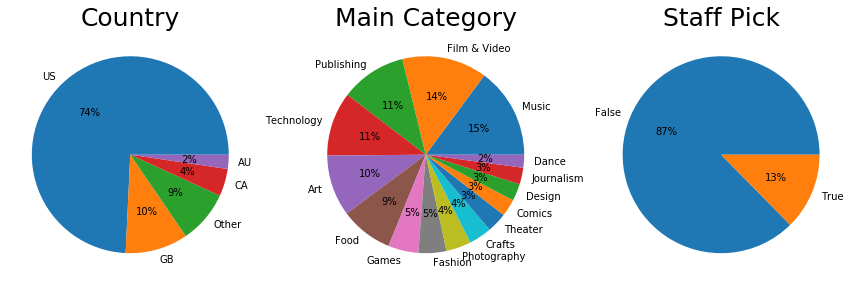

In [49]:
fsize = 15
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(15, 10))
dfTemp = data.country
dfTemp = dfTemp.apply(lambda x: "Other" if (x!='US' and x!= 'GB' and x!= 'CA' and x !='AU') else x)
dfTemp.value_counts().plot(kind='pie',title='Country',ax=axes[0],autopct='%1.0f%%',fontsize=10)
data.main_category.value_counts().plot(kind='pie',title='Main Category',ax=axes[1],autopct='%1.0f%%',fontsize=10)
data.staff_pick.value_counts().plot(kind='pie',title='Staff Pick',ax=axes[2],autopct='%1.0f%%',fontsize=10)
axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[0].title.set_size(25)
axes[1].title.set_size(25)
axes[2].title.set_size(25)
fig.subplots_adjust(wspace=0.2)
fig.savefig('pies2.eps',bbox_inches='tight')


In [50]:
scraped = pd.read_json('datasets/NewJSON')

print(len(scraped))
scraped.head()

69211


,id,imageCount,aboutText,risksText,hasVideo
0,1915206055,10,"Hello Every one!\n I'm Morgane ( Aka Mogo), ...",My biggest challenge is to draw all request...,False
1,797378694,18,IFRAME: https://www.youtube.com/embed/T3Zb5...,The biggest challenge to overcome is the lo...,True
2,2052232256,26,\n \n This Kickstarter has been created...,The book is over half way completed already...,True
3,1453436720,89,\n \n VORACIOUS is a comic book series ...,"The best part about this project is, we alr...",True
4,607417116,7,What is Piano Per Diem?\n During the mont...,"The biggest challenge will, of course, be c...",True


In [51]:
joined = scraped.merge(data, left_on='id', right_on='id')
joined.columns = joined.columns.str.replace('_x','')
print(joined.columns)
len(joined)

Index(['id', 'imageCount', 'aboutText', 'risksText', 'hasVideo', 'photo',
       'blurb', 'slug', 'disable_communication', 'country_displayable_name',
       'currency_symbol', 'currency_trailing_code', 'state_changed_at',
       'created_at', 'launched_at', 'staff_pick', 'is_starrable',
       'backers_count', 'static_usd_rate', 'usd_pledged',
       'converted_pledged_amount', 'fx_rate', 'current_currency', 'usd_type',
       'creator', 'location', 'profile', 'spotlight', 'urls', 'source_url',
       'friends', 'is_starred', 'is_backing', 'permissions', 'ID', 'name',
       'category', 'main_category', 'currency', 'deadline', 'goal', 'launched',
       'pledged', 'state', 'backers', 'country', 'usd pledged',
       'usd_pledged_real', 'usd_goal_real'],
      dtype='object')


69211

### Code to load dataset, drop columns of no use, filter the successful and unsuccessful projects and drop rows having missing values.

In [52]:
raw_features = ['id','category', 'main_category', 'deadline', 'launched', 'country', 'usd_goal_real', 'state', 'usd_pledged_real','blurb', 'imageCount','aboutText', 'risksText', 'creator', 'hasVideo']

projects_df = joined[raw_features]

print(len(projects_df.index))

success_projects_df = projects_df[projects_df.state == 'successful']
failed_projects_df = projects_df[projects_df.state == 'failed']
print(len(success_projects_df.index), len(failed_projects_df.index))

projects_df = projects_df[(projects_df.state == 'successful') | (projects_df.state == 'failed')]
print(len(projects_df.index))

projects_df = projects_df.dropna(how='any')
print(len(projects_df.index))

69211
44580 24631
69211
69210


#### Code to perform frequency encoding for the categorical features in the dataset.

In [53]:
category_freq = projects_df.groupby('category').size()/len(projects_df)
projects_df.loc[:,'category_freq'] = projects_df['category'].map(category_freq)

main_category_freq = projects_df.groupby('main_category').size()/len(projects_df)
projects_df.loc[:,'main_category_freq'] = projects_df['main_category'].map(main_category_freq)

country_freq = projects_df.groupby('country').size()/len(projects_df)
projects_df.loc[:,'country_freq'] = projects_df['country'].map(country_freq)

projects_df['launched'] = pd.to_datetime(projects_df['launched'])

launchMonths = projects_df['launched'].dt.month
launchDays = projects_df['launched'].dt.dayofweek
projects_df['launched_day'] = projects_df['launched'].dt.dayofweek

# projects_df['launched']#.dt.dayofweek
projects_df['month_sine'] = np.sin(2*np.pi*launchMonths/12)
projects_df['day_sine'] = np.sin(2*np.pi*launchDays/7)

# day_freq = projects_df.groupby('launched_day').size()/len(projects_df)
# projects_df.loc[:,'day_freq'] = projects_df['launched_day'].map(day_freq)
# month_freq = projects_df.groupby('launched_month').size()/len(projects_df)
# projects_df.loc[:,'month_freq'] = projects_df['launched_month'].map(month_freq)

#### Code to get other relvant features from the data.

In [67]:
one_hot_video = pd.get_dummies(projects_df['hasVideo'])
projects_df[['no_video', 'yes_video']] = one_hot_video

projects_df['creator'] = projects_df['creator'].apply(lambda x: x[x.find(':')+2: x.find(',')])

projects_df['launched'] = pd.to_datetime(projects_df['launched'])
projects_df['deadline'] = pd.to_datetime(projects_df['deadline'])

projects_df['is_weekend'] = projects_df['launched_day'].apply(lambda x: 1 if x>4 else 0)
one_hot_weekend = pd.get_dummies(projects_df['is_weekend'])
projects_df[['no_weekend', 'yes_weekend']] = one_hot_weekend

projects_df['duration'] = (projects_df['deadline'] - projects_df['launched']).dt.days

t2 = projects_df.groupby("main_category").agg({"usd_goal_real" : "mean", "category" : "count"})
t1 = projects_df.groupby("category").agg({"usd_goal_real" : "mean", "main_category" : "count"})
print(t2)

t2 = t2.reset_index().rename(columns={"usd_goal_real" : "mean_main_category_goal", "category" : "main_category_count"})
t1 = t1.reset_index().rename(columns={"usd_goal_real" : "mean_category_goal", "main_category" : "category_count"})
projects_df = projects_df.merge(t1, on = "category")
projects_df = projects_df.merge(t2, on = "main_category")

projects_df["diff_mean_category_goal"] = projects_df["mean_category_goal"] - projects_df["usd_goal_real"]
projects_df["diff_mean_main_category_goal"] = projects_df["mean_main_category_goal"] - projects_df["usd_goal_real"]

projects_df.replace(['successful','failed'],[1,-1],inplace=True)


               usd_goal_real  category
main_category                         
Art             55591.443947      5974
Comics           6897.606543      2447
Crafts          10332.232303      2414
Dance            6769.470872      1479
Design          55061.260926      1772
Fashion         12433.313572      3382
Film & Video   109132.495301      9906
Food            66687.605976      5370
Games           27428.731264      3710
Journalism      25542.836411      1538
Music            8121.242346     10491
Photography     12859.242390      2695
Publishing       9225.331429      7856
Technology      55588.679097      7634
Theater         36791.984197      2542


KeyError: 'mean_category_goal'

Create a table for the creators and get their features.

In [38]:
creators = data[['id', 'state', 'creator']]
creators['creator'] = creators['creator'].apply(lambda x: x[x.find(':')+2: x.find(',')])
creators = creators.rename(columns={'id': 'project_id', 'creator': 'creator_id'})

print(creators.shape)

(131919, 3)


/home/nic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [39]:
one_hot_state = pd.get_dummies(creators['state'])
creators[one_hot_state.columns] = one_hot_state

creator_counts = creators.groupby('creator_id')['project_id'].count().reset_index()
creator_success_counts = creators.loc[creators['successful']==1].groupby('creator_id')['project_id'].count().reset_index()

creator_joined = creator_counts.merge(creator_success_counts, left_on='creator_id', right_on='creator_id', how='outer')
creator_joined.loc[creator_joined['project_id_y'].isna(), 'project_id_y'] = 0
creator_joined = creator_joined.rename(columns={'project_id_x': 'creator_total', 'project_id_y': 'creator_successful'})

In [40]:
print(projects_df.shape)
projects_df = projects_df.merge(creator_joined, left_on='creator', right_on='creator_id')
print(projects_df.shape)

(69210, 33)
(69210, 36)


In [41]:
pd.set_option('display.max_columns', None)
projects_df.columns

Index(['id', 'category', 'main_category', 'deadline', 'launched', 'country',
       'usd_goal_real', 'state', 'usd_pledged_real', 'blurb', 'imageCount',
       'aboutText', 'risksText', 'creator', 'hasVideo', 'category_freq',
       'main_category_freq', 'country_freq', 'launched_day', 'month_sine',
       'day_sine', 'no_video', 'yes_video', 'is_weekend', 'no_weekend',
       'yes_weekend', 'duration', 'mean_category_goal', 'category_count',
       'mean_main_category_goal', 'main_category_count',
       'diff_mean_category_goal', 'diff_mean_main_category_goal', 'creator_id',
       'creator_total', 'creator_successful'],
      dtype='object')

In [42]:
textData = pd.read_csv("datasets/textData.csv",engine='python',error_bad_lines=False)

textData.describe()

projects_df = projects_df.merge(textData, left_on='id', right_on='id')

Clean the text columns. 

In [43]:
# projects_df['blurb'] = projects_df['blurb'].apply(lambda x: re.sub(r'https:\\*/\\*/.*?\s', '', x.strip().replace('\n', '')))
# projects_df['aboutText'] = projects_df['aboutText'].apply(lambda x: re.sub(r'https:\\*/\\*/.*?\s', '', x.strip().replace('\n', '')))
# projects_df['risksText'] = projects_df['risksText'].apply(lambda x: re.sub(r'https:\\*/\\*/.*?\s', '', x.strip().replace('\n', '')))


Get all the text related features.

In [44]:
# %%time
# dic = pyphen.Pyphen(lang='en')
# spell = SpellChecker()

# projects_df['blurbNumWords'] = projects_df['blurb'].apply(lambda x: len(word_tokenize(x)))
# print("NumWordsDone")
# projects_df['blurbNumSents'] = projects_df['blurb'].apply(lambda x: len(sent_tokenize(x)))
# print("NumSentsDone")
# projects_df['blurbAvgSentLength'] = projects_df['blurb'].apply(lambda x: float(sum([len(word_tokenize(sent)) for sent in sent_tokenize(x)]))/(len(sent_tokenize(x))+1))
# print("NumAVGDone")
# projects_df['blurbMaxSyllables'] = projects_df['blurb'].apply(lambda x: max([len(dic.inserted(word).split('-')) for word in word_tokenize(x)], default=0))
# print("NumMaxDone")
# projects_df['blurbSpellingErrors'] = projects_df['blurb'].apply(lambda x: len(spell.unknown(word_tokenize(x))))
# print("NumErrDone")

# projects_df['aboutNumWords'] = projects_df['aboutText'].apply(lambda x: len(word_tokenize(x)))
# print("NumWordsDone")
# projects_df['aboutNumSents'] = projects_df['aboutText'].apply(lambda x: len(sent_tokenize(x)))
# print("NumSentsDone")
# projects_df['aboutAvgSentLength'] = projects_df['aboutText'].apply(lambda x: float(sum([len(word_tokenize(sent)) for sent in sent_tokenize(x)]))/(len(sent_tokenize(x))+1))
# print("NumAVGDone")
# projects_df['aboutMaxSyllables'] = projects_df['aboutText'].apply(lambda x: max([len(dic.inserted(word).split('-')) for word in word_tokenize(x)], default=0))
# print("NumMaxDone")
# projects_df['aboutSpellingErrors'] = projects_df['aboutText'].apply(lambda x: len(spell.unknown(word_tokenize(x))))
# print("NumErrDone")

# projects_df['risksNumWords'] = projects_df['risksText'].apply(lambda x: len(word_tokenize(x)))
# print("NumWordsDone")
# projects_df['risksNumSents'] = projects_df['risksText'].apply(lambda x: len(sent_tokenize(x)))
# print("NumSentsDone")
# projects_df['risksAvgSentLength'] = projects_df['risksText'].apply(lambda x: float(sum([len(word_tokenize(sent)) for sent in sent_tokenize(x)]))/(len(sent_tokenize(x))+1))
# print("NumAVGDone")
# projects_df['risksMaxSyllables'] = projects_df['risksText'].apply(lambda x: max([len(dic.inserted(word).split('-')) for word in word_tokenize(x)], default=0))
# print("NumMaxDone")
# projects_df['risksSpellingErrors'] = projects_df['risksText'].apply(lambda x: len(spell.unknown(word_tokenize(x))))
# print("NumErrDone")

In [45]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

projects_df.head()

,id,category,main_category,deadline,launched,country,usd_goal_real,state,usd_pledged_real,blurb,imageCount,aboutText,risksText,creator,hasVideo,category_freq,main_category_freq,country_freq,launched_day,month_sine,day_sine,no_video,yes_video,is_weekend,no_weekend,yes_weekend,duration,mean_category_goal,category_count,mean_main_category_goal,main_category_count,diff_mean_category_goal,diff_mean_main_category_goal,creator_id,creator_total,creator_successful,blurbNumWords,blurbNumSents,blurbAvgSentLength,blurbMaxSyllables,blurbSpellingErrors,aboutNumWords,aboutNumSents,aboutAvgSentLength,aboutMaxSyllables,aboutSpellingErrors,risksNumWords,risksNumSents,risksAvgSentLength,risksMaxSyllables,risksSpellingErrors
0,1915206055,Illustration,Art,2016-08-05,2016-07-06 20:39:49,FR,11.16,1,100.40,Request ink drawings or Random Prints . Severa...,10,"Hello Every one!\n I'm Morgane ( Aka Mogo), ...",My biggest challenge is to draw all request...,1190073103,False,0.012412,0.086317,0.010620,2,-0.500000,0.974928,1,0,0,1,0,29,2196.850221,859,55591.443947,5974,2185.690221,55580.283947,1190073103,1,1.0,20,2,6.666667,3,0,363,20,17.285714,5,50,71,2,23.666667,3,13
1,1426917472,Illustration,Art,2016-03-05,2016-02-01 18:01:45,US,7500.00,1,28861.00,44-card Oracle Deck Featuring Magical Cat Illu...,30,Please SHARE THIS PROJECT with the buttons abo...,"I have completed the art, writing, and desi...",1533542441,True,0.012412,0.086317,0.730588,0,0.866025,0.000000,0,1,0,1,0,32,2196.850221,859,55591.443947,5974,-5303.149779,48091.443947,1533542441,1,1.0,21,3,5.250000,4,1,1560,84,18.352941,7,59,93,6,13.285714,5,1
2,1868814243,Illustration,Art,2017-05-10,2017-04-10 17:34:52,ES,7613.16,1,14049.55,An accordion-shaped artbook with an immense 5 ...,52,"\n Now that we've reached the goal, I've ...","My last crowdfunding project, The Draftsman...",1303021081,True,0.012412,0.086317,0.007008,0,0.866025,0.000000,0,1,0,1,0,29,2196.850221,859,55591.443947,5974,-5416.309779,47978.283947,1303021081,1,1.0,24,2,8.000000,4,4,919,38,23.564103,5,40,89,4,17.800000,4,6
3,1354777743,Illustration,Art,2015-05-06,2015-04-21 17:33:10,GB,169.55,1,863.16,A beautiful coloring book of animals from acr...,27,Thank you for your support everyone! I didn...,The art for the book is already completed a...,1382679986,True,0.012412,0.086317,0.114246,1,0.866025,0.781831,0,1,0,1,0,14,2196.850221,859,55591.443947,5974,2027.300221,55421.893947,1382679986,6,5.0,25,3,6.250000,4,1,890,42,20.697674,4,28,68,3,17.000000,4,2
4,1957887397,Illustration,Art,2016-02-17,2016-01-18 06:47:48,US,800.00,1,1725.00,A dog coloring book full of super cool doggy d...,39,\nDREAM DELUXE EDITION STRETCH GOAL UNLOCKE...,The art for the book is already completed a...,1382679986,True,0.012412,0.086317,0.730588,0,0.500000,0.000000,0,1,0,1,0,29,2196.850221,859,55591.443947,5974,1396.850221,54791.443947,1382679986,6,5.0,26,3,6.500000,4,1,987,50,19.352941,4,32,101,5,16.833333,4,3


#### Code to drop features we don't need anymore.

In [46]:
print(projects_df.columns)
projects_df = projects_df.drop(["category", "main_category","launched_day", "deadline", "country", "is_weekend", "hasVideo", "blurb", "aboutText", "risksText", "creator"], axis = 1)
# projects_df = projects_df.drop(["category", "main_category", "launched","launched_day", "deadline", "country", "is_weekend", "hasVideo", "blurb", "aboutText", "risksText", "creator", "creator_id"], axis = 1)

print(projects_df.shape)
print(projects_df.columns)
projects_df.head()

Index(['id', 'category', 'main_category', 'deadline', 'launched', 'country',
       'usd_goal_real', 'state', 'usd_pledged_real', 'blurb', 'imageCount',
       'aboutText', 'risksText', 'creator', 'hasVideo', 'category_freq',
       'main_category_freq', 'country_freq', 'launched_day', 'month_sine',
       'day_sine', 'no_video', 'yes_video', 'is_weekend', 'no_weekend',
       'yes_weekend', 'duration', 'mean_category_goal', 'category_count',
       'mean_main_category_goal', 'main_category_count',
       'diff_mean_category_goal', 'diff_mean_main_category_goal', 'creator_id',
       'creator_total', 'creator_successful', 'blurbNumWords', 'blurbNumSents',
       'blurbAvgSentLength', 'blurbMaxSyllables', 'blurbSpellingErrors',
       'aboutNumWords', 'aboutNumSents', 'aboutAvgSentLength',
       'aboutMaxSyllables', 'aboutSpellingErrors', 'risksNumWords',
       'risksNumSents', 'risksAvgSentLength', 'risksMaxSyllables',
       'risksSpellingErrors'],
      dtype='object')
(69210, 40)


,id,launched,usd_goal_real,state,usd_pledged_real,imageCount,category_freq,main_category_freq,country_freq,month_sine,day_sine,no_video,yes_video,no_weekend,yes_weekend,duration,mean_category_goal,category_count,mean_main_category_goal,main_category_count,diff_mean_category_goal,diff_mean_main_category_goal,creator_id,creator_total,creator_successful,blurbNumWords,blurbNumSents,blurbAvgSentLength,blurbMaxSyllables,blurbSpellingErrors,aboutNumWords,aboutNumSents,aboutAvgSentLength,aboutMaxSyllables,aboutSpellingErrors,risksNumWords,risksNumSents,risksAvgSentLength,risksMaxSyllables,risksSpellingErrors
0,1915206055,2016-07-06 20:39:49,11.16,1,100.40,10,0.012412,0.086317,0.010620,-0.500000,0.974928,1,0,1,0,29,2196.850221,859,55591.443947,5974,2185.690221,55580.283947,1190073103,1,1.0,20,2,6.666667,3,0,363,20,17.285714,5,50,71,2,23.666667,3,13
1,1426917472,2016-02-01 18:01:45,7500.00,1,28861.00,30,0.012412,0.086317,0.730588,0.866025,0.000000,0,1,1,0,32,2196.850221,859,55591.443947,5974,-5303.149779,48091.443947,1533542441,1,1.0,21,3,5.250000,4,1,1560,84,18.352941,7,59,93,6,13.285714,5,1
2,1868814243,2017-04-10 17:34:52,7613.16,1,14049.55,52,0.012412,0.086317,0.007008,0.866025,0.000000,0,1,1,0,29,2196.850221,859,55591.443947,5974,-5416.309779,47978.283947,1303021081,1,1.0,24,2,8.000000,4,4,919,38,23.564103,5,40,89,4,17.800000,4,6
3,1354777743,2015-04-21 17:33:10,169.55,1,863.16,27,0.012412,0.086317,0.114246,0.866025,0.781831,0,1,1,0,14,2196.850221,859,55591.443947,5974,2027.300221,55421.893947,1382679986,6,5.0,25,3,6.250000,4,1,890,42,20.697674,4,28,68,3,17.000000,4,2
4,1957887397,2016-01-18 06:47:48,800.00,1,1725.00,39,0.012412,0.086317,0.730588,0.500000,0.000000,0,1,1,0,29,2196.850221,859,55591.443947,5974,1396.850221,54791.443947,1382679986,6,5.0,26,3,6.500000,4,1,987,50,19.352941,4,32,101,5,16.833333,4,3


Replacing the values is 'state' variable.

Download the dataset for performing Stanford CoreNLP sentiment analysis.

In [47]:
creator_unique_id = np.unique(projects_df.creator_id)
creator_unique_id.shape

(63373,)

In [91]:
tmp=0
mylist = []
for cid in creator_unique_id:
    c_projects = projects_df[projects_df.creator_id==cid].sort_values(by='launched').copy()
    successCount=0
    totalCount=0
    for index, row in c_projects.iterrows():
        pid = row.id
#         projects_df.loc[projects_df['id']==pid, ['creator_successful']]=successCount
#         projects_df.loc[projects_df['id']==pid, ['creator_total']]=totalCount
        mylist.append({'id': pid, 'cSuccess': successCount,'cTotal': totalCount})
        if row.state==1:
            successCount=successCount+1
        totalCount = totalCount+1
        tmp=tmp+1
        print(tmp," ", successCount)

1   1
2   1
3   1
4   2
5   1
6   0
7   0
8   0
9   1
10   1
11   0
12   0
13   1
14   1
15   2
16   1
17   1
18   0
19   1
20   1
21   0
22   1
23   2
24   1
25   1
26   1
27   2
28   1
29   1
30   0
31   0
32   0
33   1
34   1
35   0
36   0
37   0
38   0
39   0
40   1
41   2
42   1
43   1
44   1
45   1
46   1
47   1
48   1
49   2
50   1
51   1
52   0
53   1
54   0
55   1
56   1
57   0
58   0
59   0
60   1
61   0
62   1
63   1
64   0
65   0
66   0
67   1
68   2
69   3
70   1
71   0
72   1
73   1
74   0
75   1
76   0
77   0
78   1
79   1
80   0
81   1
82   0
83   0
84   0
85   0
86   1
87   1
88   1
89   1
90   1
91   0
92   1
93   1
94   1
95   1
96   2
97   1
98   1
99   1
100   1
101   1
102   2
103   1
104   0
105   1
106   1
107   1
108   2
109   1
110   1
111   0
112   1
113   1
114   0
115   0
116   1
117   1
118   0
119   0
120   1
121   0
122   1
123   1
124   1
125   1
126   1
127   1
128   1
129   0
130   1
131   1
132   0
133   1
134   1
135   1
136   1
137   0
138   1
139 

1046   1
1047   0
1048   0
1049   1
1050   0
1051   1
1052   1
1053   1
1054   1
1055   1
1056   2
1057   0
1058   1
1059   1
1060   1
1061   0
1062   1
1063   1
1064   1
1065   2
1066   1
1067   1
1068   1
1069   1
1070   0
1071   0
1072   1
1073   1
1074   1
1075   1
1076   1
1077   2
1078   0
1079   1
1080   1
1081   1
1082   0
1083   1
1084   0
1085   0
1086   0
1087   0
1088   1
1089   1
1090   2
1091   0
1092   0
1093   0
1094   1
1095   1
1096   1
1097   1
1098   1
1099   1
1100   1
1101   0
1102   0
1103   1
1104   1
1105   1
1106   1
1107   1
1108   1
1109   1
1110   0
1111   1
1112   0
1113   0
1114   1
1115   0
1116   0
1117   1
1118   0
1119   0
1120   0
1121   1
1122   1
1123   0
1124   1
1125   1
1126   1
1127   1
1128   0
1129   1
1130   1
1131   1
1132   1
1133   1
1134   1
1135   1
1136   1
1137   0
1138   1
1139   0
1140   0
1141   1
1142   1
1143   2
1144   1
1145   0
1146   1
1147   0
1148   1
1149   1
1150   1
1151   0
1152   0
1153   1
1154   1
1155   0
1156   1
1

1959   1
1960   0
1961   0
1962   0
1963   1
1964   1
1965   0
1966   1
1967   0
1968   0
1969   1
1970   1
1971   1
1972   1
1973   1
1974   0
1975   0
1976   1
1977   0
1978   1
1979   0
1980   0
1981   0
1982   1
1983   1
1984   1
1985   1
1986   1
1987   0
1988   1
1989   1
1990   1
1991   1
1992   1
1993   1
1994   0
1995   0
1996   0
1997   0
1998   1
1999   1
2000   0
2001   0
2002   0
2003   0
2004   1
2005   1
2006   0
2007   1
2008   1
2009   1
2010   0
2011   1
2012   2
2013   1
2014   1
2015   0
2016   1
2017   1
2018   1
2019   1
2020   2
2021   1
2022   1
2023   1
2024   1
2025   1
2026   0
2027   0
2028   1
2029   0
2030   1
2031   1
2032   2
2033   1
2034   1
2035   1
2036   0
2037   1
2038   1
2039   0
2040   0
2041   1
2042   0
2043   0
2044   1
2045   1
2046   1
2047   1
2048   1
2049   1
2050   1
2051   1
2052   1
2053   1
2054   1
2055   2
2056   3
2057   4
2058   5
2059   0
2060   1
2061   1
2062   0
2063   0
2064   1
2065   0
2066   1
2067   0
2068   1
2069   1
2

2879   1
2880   1
2881   1
2882   1
2883   0
2884   1
2885   1
2886   0
2887   1
2888   1
2889   0
2890   1
2891   1
2892   2
2893   1
2894   0
2895   0
2896   0
2897   1
2898   2
2899   1
2900   1
2901   1
2902   1
2903   1
2904   1
2905   0
2906   1
2907   1
2908   0
2909   0
2910   1
2911   0
2912   1
2913   0
2914   0
2915   0
2916   0
2917   0
2918   1
2919   1
2920   1
2921   1
2922   1
2923   1
2924   1
2925   0
2926   1
2927   1
2928   1
2929   1
2930   1
2931   1
2932   1
2933   0
2934   0
2935   0
2936   1
2937   1
2938   1
2939   1
2940   1
2941   2
2942   0
2943   1
2944   1
2945   0
2946   1
2947   0
2948   1
2949   0
2950   0
2951   1
2952   0
2953   0
2954   1
2955   0
2956   1
2957   0
2958   0
2959   0
2960   1
2961   0
2962   0
2963   1
2964   1
2965   1
2966   0
2967   1
2968   1
2969   0
2970   0
2971   0
2972   1
2973   0
2974   1
2975   1
2976   0
2977   1
2978   0
2979   0
2980   1
2981   1
2982   0
2983   0
2984   1
2985   1
2986   2
2987   3
2988   0
2989   0
2

3794   1
3795   1
3796   1
3797   1
3798   1
3799   1
3800   1
3801   1
3802   1
3803   1
3804   1
3805   1
3806   0
3807   1
3808   2
3809   3
3810   1
3811   1
3812   0
3813   0
3814   1
3815   1
3816   0
3817   0
3818   1
3819   1
3820   1
3821   0
3822   0
3823   1
3824   0
3825   0
3826   1
3827   1
3828   1
3829   0
3830   1
3831   0
3832   1
3833   0
3834   1
3835   1
3836   0
3837   1
3838   0
3839   1
3840   1
3841   2
3842   1
3843   1
3844   1
3845   1
3846   1
3847   1
3848   1
3849   1
3850   1
3851   1
3852   0
3853   1
3854   0
3855   0
3856   1
3857   0
3858   1
3859   1
3860   1
3861   1
3862   1
3863   1
3864   1
3865   2
3866   0
3867   1
3868   0
3869   0
3870   1
3871   1
3872   0
3873   1
3874   1
3875   0
3876   1
3877   0
3878   1
3879   1
3880   1
3881   1
3882   0
3883   0
3884   0
3885   1
3886   0
3887   1
3888   1
3889   1
3890   0
3891   1
3892   0
3893   1
3894   1
3895   1
3896   0
3897   1
3898   2
3899   1
3900   1
3901   0
3902   1
3903   1
3904   1
3

4718   1
4719   0
4720   0
4721   1
4722   1
4723   0
4724   0
4725   0
4726   0
4727   1
4728   1
4729   0
4730   0
4731   0
4732   1
4733   1
4734   1
4735   0
4736   1
4737   1
4738   1
4739   0
4740   0
4741   1
4742   1
4743   0
4744   1
4745   0
4746   1
4747   0
4748   1
4749   1
4750   1
4751   1
4752   1
4753   1
4754   1
4755   1
4756   0
4757   1
4758   1
4759   0
4760   1
4761   0
4762   0
4763   1
4764   1
4765   1
4766   0
4767   1
4768   1
4769   1
4770   1
4771   1
4772   1
4773   0
4774   1
4775   0
4776   1
4777   0
4778   0
4779   1
4780   1
4781   1
4782   0
4783   1
4784   0
4785   0
4786   0
4787   1
4788   1
4789   0
4790   0
4791   1
4792   0
4793   1
4794   2
4795   0
4796   1
4797   0
4798   0
4799   1
4800   1
4801   1
4802   0
4803   1
4804   1
4805   0
4806   0
4807   0
4808   0
4809   1
4810   1
4811   1
4812   0
4813   1
4814   1
4815   1
4816   0
4817   0
4818   1
4819   1
4820   0
4821   1
4822   2
4823   1
4824   1
4825   1
4826   1
4827   1
4828   1
4

5629   1
5630   0
5631   1
5632   0
5633   1
5634   2
5635   1
5636   0
5637   0
5638   1
5639   1
5640   0
5641   1
5642   1
5643   1
5644   1
5645   1
5646   2
5647   3
5648   0
5649   1
5650   0
5651   1
5652   0
5653   0
5654   0
5655   0
5656   0
5657   1
5658   1
5659   1
5660   1
5661   1
5662   0
5663   1
5664   0
5665   1
5666   0
5667   1
5668   1
5669   1
5670   0
5671   1
5672   0
5673   0
5674   0
5675   1
5676   2
5677   1
5678   0
5679   1
5680   0
5681   1
5682   0
5683   1
5684   0
5685   1
5686   0
5687   0
5688   0
5689   1
5690   1
5691   1
5692   0
5693   1
5694   1
5695   1
5696   0
5697   0
5698   1
5699   1
5700   0
5701   1
5702   2
5703   1
5704   1
5705   1
5706   0
5707   0
5708   1
5709   2
5710   0
5711   0
5712   1
5713   1
5714   0
5715   1
5716   0
5717   1
5718   1
5719   0
5720   1
5721   0
5722   1
5723   1
5724   0
5725   0
5726   0
5727   1
5728   0
5729   0
5730   1
5731   0
5732   1
5733   0
5734   1
5735   0
5736   0
5737   1
5738   1
5739   0
5

6542   1
6543   0
6544   1
6545   1
6546   1
6547   2
6548   3
6549   4
6550   5
6551   6
6552   1
6553   1
6554   1
6555   1
6556   1
6557   2
6558   0
6559   1
6560   1
6561   1
6562   2
6563   1
6564   0
6565   1
6566   0
6567   0
6568   1
6569   0
6570   0
6571   1
6572   1
6573   1
6574   1
6575   0
6576   0
6577   1
6578   0
6579   1
6580   0
6581   1
6582   0
6583   1
6584   1
6585   1
6586   1
6587   1
6588   0
6589   1
6590   0
6591   1
6592   0
6593   1
6594   1
6595   1
6596   1
6597   1
6598   0
6599   0
6600   1
6601   0
6602   1
6603   1
6604   0
6605   0
6606   0
6607   0
6608   1
6609   1
6610   0
6611   0
6612   1
6613   0
6614   0
6615   1
6616   0
6617   0
6618   1
6619   0
6620   0
6621   1
6622   1
6623   1
6624   1
6625   1
6626   1
6627   1
6628   1
6629   0
6630   1
6631   1
6632   1
6633   1
6634   1
6635   1
6636   0
6637   1
6638   0
6639   1
6640   1
6641   1
6642   1
6643   0
6644   1
6645   0
6646   1
6647   1
6648   1
6649   1
6650   0
6651   0
6652   1
6

7463   1
7464   0
7465   1
7466   1
7467   0
7468   1
7469   0
7470   0
7471   1
7472   1
7473   0
7474   0
7475   1
7476   1
7477   1
7478   0
7479   0
7480   0
7481   0
7482   1
7483   1
7484   1
7485   1
7486   1
7487   0
7488   1
7489   1
7490   0
7491   0
7492   1
7493   1
7494   1
7495   1
7496   1
7497   0
7498   1
7499   1
7500   0
7501   0
7502   0
7503   1
7504   1
7505   0
7506   1
7507   1
7508   2
7509   1
7510   1
7511   1
7512   1
7513   0
7514   1
7515   1
7516   1
7517   2
7518   3
7519   4
7520   4
7521   5
7522   6
7523   7
7524   7
7525   8
7526   9
7527   0
7528   1
7529   1
7530   1
7531   0
7532   1
7533   1
7534   0
7535   0
7536   0
7537   1
7538   0
7539   1
7540   1
7541   0
7542   1
7543   1
7544   1
7545   1
7546   1
7547   1
7548   1
7549   0
7550   0
7551   1
7552   1
7553   0
7554   1
7555   1
7556   1
7557   1
7558   0
7559   1
7560   1
7561   1
7562   1
7563   1
7564   0
7565   1
7566   1
7567   1
7568   1
7569   1
7570   2
7571   3
7572   4
7573   5
7

8379   0
8380   0
8381   0
8382   0
8383   0
8384   1
8385   1
8386   1
8387   1
8388   0
8389   1
8390   0
8391   0
8392   0
8393   1
8394   0
8395   1
8396   0
8397   0
8398   0
8399   1
8400   0
8401   0
8402   1
8403   1
8404   1
8405   0
8406   1
8407   1
8408   0
8409   1
8410   0
8411   0
8412   1
8413   1
8414   1
8415   0
8416   1
8417   0
8418   1
8419   1
8420   1
8421   1
8422   1
8423   1
8424   0
8425   1
8426   1
8427   1
8428   1
8429   1
8430   1
8431   1
8432   0
8433   1
8434   1
8435   2
8436   1
8437   1
8438   1
8439   1
8440   1
8441   1
8442   1
8443   0
8444   1
8445   0
8446   1
8447   0
8448   1
8449   1
8450   1
8451   1
8452   1
8453   1
8454   1
8455   1
8456   1
8457   1
8458   0
8459   0
8460   1
8461   1
8462   1
8463   1
8464   1
8465   1
8466   0
8467   1
8468   1
8469   0
8470   0
8471   0
8472   1
8473   1
8474   1
8475   0
8476   1
8477   0
8478   0
8479   1
8480   1
8481   1
8482   1
8483   1
8484   1
8485   1
8486   0
8487   1
8488   0
8489   1
8

9306   1
9307   1
9308   1
9309   1
9310   0
9311   1
9312   1
9313   1
9314   0
9315   1
9316   0
9317   1
9318   0
9319   1
9320   0
9321   0
9322   0
9323   1
9324   1
9325   1
9326   1
9327   1
9328   1
9329   1
9330   0
9331   0
9332   0
9333   1
9334   1
9335   0
9336   1
9337   1
9338   0
9339   1
9340   1
9341   1
9342   1
9343   1
9344   2
9345   1
9346   1
9347   0
9348   1
9349   1
9350   1
9351   0
9352   0
9353   1
9354   0
9355   1
9356   1
9357   1
9358   0
9359   1
9360   0
9361   0
9362   0
9363   1
9364   1
9365   1
9366   1
9367   0
9368   1
9369   0
9370   0
9371   0
9372   0
9373   1
9374   1
9375   1
9376   2
9377   0
9378   1
9379   1
9380   1
9381   0
9382   1
9383   1
9384   1
9385   2
9386   0
9387   0
9388   1
9389   1
9390   1
9391   1
9392   1
9393   1
9394   1
9395   1
9396   2
9397   3
9398   1
9399   1
9400   1
9401   1
9402   1
9403   0
9404   1
9405   0
9406   1
9407   0
9408   1
9409   0
9410   1
9411   1
9412   1
9413   1
9414   0
9415   1
9416   0
9

10197   1
10198   1
10199   1
10200   0
10201   1
10202   2
10203   3
10204   1
10205   2
10206   1
10207   0
10208   0
10209   1
10210   0
10211   0
10212   0
10213   0
10214   0
10215   0
10216   1
10217   0
10218   0
10219   0
10220   0
10221   1
10222   0
10223   0
10224   1
10225   1
10226   1
10227   1
10228   2
10229   1
10230   1
10231   0
10232   1
10233   2
10234   0
10235   1
10236   1
10237   1
10238   1
10239   1
10240   0
10241   1
10242   1
10243   1
10244   1
10245   1
10246   1
10247   0
10248   1
10249   0
10250   0
10251   0
10252   0
10253   0
10254   1
10255   1
10256   1
10257   2
10258   0
10259   0
10260   1
10261   1
10262   1
10263   1
10264   1
10265   1
10266   0
10267   1
10268   0
10269   0
10270   0
10271   1
10272   1
10273   1
10274   1
10275   1
10276   1
10277   0
10278   1
10279   1
10280   1
10281   0
10282   1
10283   1
10284   2
10285   3
10286   0
10287   0
10288   1
10289   1
10290   1
10291   1
10292   1
10293   2
10294   0
10295   1
10296   1


11030   0
11031   1
11032   2
11033   3
11034   1
11035   0
11036   1
11037   1
11038   2
11039   3
11040   1
11041   1
11042   1
11043   1
11044   1
11045   1
11046   1
11047   1
11048   1
11049   1
11050   1
11051   1
11052   1
11053   0
11054   0
11055   1
11056   0
11057   0
11058   0
11059   0
11060   1
11061   1
11062   0
11063   0
11064   1
11065   1
11066   1
11067   1
11068   1
11069   1
11070   1
11071   1
11072   1
11073   1
11074   1
11075   0
11076   1
11077   0
11078   1
11079   1
11080   2
11081   0
11082   1
11083   2
11084   1
11085   0
11086   1
11087   0
11088   1
11089   1
11090   2
11091   3
11092   4
11093   1
11094   1
11095   0
11096   1
11097   1
11098   1
11099   2
11100   0
11101   1
11102   1
11103   0
11104   1
11105   1
11106   1
11107   1
11108   1
11109   0
11110   1
11111   1
11112   0
11113   1
11114   0
11115   0
11116   1
11117   1
11118   1
11119   1
11120   1
11121   1
11122   1
11123   1
11124   1
11125   1
11126   1
11127   1
11128   1
11129   1


11859   1
11860   1
11861   1
11862   0
11863   0
11864   0
11865   1
11866   1
11867   0
11868   1
11869   0
11870   1
11871   1
11872   1
11873   1
11874   0
11875   1
11876   1
11877   1
11878   1
11879   0
11880   1
11881   1
11882   1
11883   1
11884   1
11885   0
11886   1
11887   0
11888   1
11889   1
11890   0
11891   1
11892   1
11893   0
11894   1
11895   1
11896   0
11897   1
11898   1
11899   0
11900   1
11901   0
11902   0
11903   0
11904   1
11905   1
11906   0
11907   0
11908   1
11909   0
11910   0
11911   1
11912   0
11913   1
11914   2
11915   0
11916   1
11917   1
11918   1
11919   1
11920   1
11921   1
11922   0
11923   0
11924   0
11925   0
11926   0
11927   1
11928   1
11929   0
11930   0
11931   0
11932   1
11933   1
11934   0
11935   1
11936   1
11937   0
11938   0
11939   1
11940   1
11941   1
11942   0
11943   0
11944   1
11945   0
11946   1
11947   1
11948   1
11949   1
11950   0
11951   0
11952   1
11953   2
11954   1
11955   1
11956   0
11957   1
11958   1


12697   1
12698   1
12699   0
12700   1
12701   1
12702   1
12703   0
12704   1
12705   0
12706   1
12707   2
12708   0
12709   1
12710   1
12711   0
12712   0
12713   0
12714   0
12715   1
12716   0
12717   0
12718   1
12719   1
12720   0
12721   1
12722   0
12723   0
12724   1
12725   1
12726   0
12727   1
12728   0
12729   1
12730   1
12731   1
12732   1
12733   0
12734   1
12735   0
12736   0
12737   0
12738   0
12739   1
12740   0
12741   1
12742   2
12743   3
12744   1
12745   0
12746   0
12747   0
12748   1
12749   1
12750   1
12751   0
12752   1
12753   2
12754   0
12755   1
12756   1
12757   0
12758   0
12759   0
12760   1
12761   2
12762   1
12763   1
12764   1
12765   0
12766   1
12767   0
12768   1
12769   2
12770   1
12771   1
12772   1
12773   1
12774   1
12775   1
12776   1
12777   1
12778   0
12779   1
12780   1
12781   1
12782   1
12783   0
12784   0
12785   0
12786   1
12787   1
12788   0
12789   1
12790   0
12791   0
12792   1
12793   2
12794   0
12795   1
12796   1


13526   1
13527   1
13528   1
13529   1
13530   1
13531   1
13532   1
13533   0
13534   1
13535   2
13536   1
13537   1
13538   1
13539   1
13540   1
13541   1
13542   1
13543   1
13544   0
13545   1
13546   0
13547   1
13548   0
13549   1
13550   1
13551   2
13552   1
13553   0
13554   1
13555   1
13556   1
13557   0
13558   1
13559   1
13560   0
13561   1
13562   1
13563   2
13564   3
13565   4
13566   5
13567   6
13568   7
13569   0
13570   1
13571   0
13572   0
13573   1
13574   0
13575   0
13576   0
13577   1
13578   1
13579   0
13580   0
13581   1
13582   1
13583   1
13584   1
13585   2
13586   0
13587   0
13588   1
13589   2
13590   1
13591   1
13592   0
13593   1
13594   0
13595   0
13596   0
13597   0
13598   0
13599   1
13600   0
13601   1
13602   1
13603   0
13604   0
13605   1
13606   0
13607   1
13608   1
13609   1
13610   1
13611   0
13612   1
13613   0
13614   1
13615   2
13616   1
13617   2
13618   3
13619   3
13620   4
13621   0
13622   1
13623   0
13624   1
13625   1


14361   1
14362   1
14363   1
14364   0
14365   1
14366   0
14367   1
14368   1
14369   0
14370   0
14371   0
14372   1
14373   0
14374   1
14375   1
14376   0
14377   0
14378   1
14379   0
14380   1
14381   0
14382   1
14383   0
14384   1
14385   2
14386   1
14387   0
14388   1
14389   0
14390   1
14391   0
14392   1
14393   0
14394   1
14395   1
14396   0
14397   0
14398   1
14399   1
14400   1
14401   1
14402   1
14403   0
14404   0
14405   0
14406   0
14407   1
14408   1
14409   0
14410   0
14411   0
14412   1
14413   1
14414   0
14415   1
14416   0
14417   1
14418   1
14419   0
14420   0
14421   1
14422   0
14423   0
14424   1
14425   1
14426   0
14427   0
14428   1
14429   1
14430   1
14431   1
14432   1
14433   2
14434   0
14435   1
14436   1
14437   0
14438   1
14439   1
14440   0
14441   1
14442   1
14443   2
14444   0
14445   1
14446   1
14447   1
14448   2
14449   1
14450   0
14451   0
14452   0
14453   0
14454   0
14455   1
14456   0
14457   0
14458   1
14459   1
14460   1


15187   1
15188   2
15189   1
15190   0
15191   0
15192   1
15193   0
15194   1
15195   0
15196   0
15197   0
15198   1
15199   1
15200   0
15201   1
15202   1
15203   0
15204   0
15205   1
15206   1
15207   1
15208   0
15209   1
15210   1
15211   1
15212   1
15213   0
15214   1
15215   2
15216   1
15217   1
15218   0
15219   1
15220   1
15221   2
15222   3
15223   1
15224   1
15225   0
15226   1
15227   1
15228   1
15229   1
15230   1
15231   2
15232   3
15233   1
15234   1
15235   1
15236   0
15237   1
15238   1
15239   1
15240   1
15241   0
15242   1
15243   1
15244   1
15245   1
15246   1
15247   0
15248   1
15249   2
15250   3
15251   4
15252   5
15253   6
15254   7
15255   8
15256   9
15257   10
15258   0
15259   1
15260   0
15261   0
15262   1
15263   1
15264   0
15265   0
15266   0
15267   1
15268   0
15269   1
15270   0
15271   0
15272   1
15273   1
15274   0
15275   0
15276   1
15277   1
15278   1
15279   1
15280   0
15281   0
15282   1
15283   1
15284   1
15285   1
15286   1

16010   0
16011   0
16012   0
16013   1
16014   1
16015   0
16016   0
16017   0
16018   1
16019   0
16020   0
16021   0
16022   1
16023   1
16024   0
16025   0
16026   0
16027   1
16028   2
16029   3
16030   0
16031   1
16032   0
16033   1
16034   1
16035   1
16036   0
16037   0
16038   0
16039   0
16040   1
16041   0
16042   0
16043   0
16044   1
16045   1
16046   1
16047   0
16048   1
16049   1
16050   0
16051   1
16052   1
16053   0
16054   1
16055   1
16056   1
16057   0
16058   1
16059   1
16060   0
16061   0
16062   1
16063   0
16064   1
16065   1
16066   2
16067   1
16068   2
16069   3
16070   1
16071   1
16072   0
16073   0
16074   1
16075   1
16076   0
16077   1
16078   0
16079   1
16080   1
16081   1
16082   1
16083   1
16084   1
16085   1
16086   1
16087   1
16088   1
16089   0
16090   0
16091   0
16092   1
16093   1
16094   0
16095   1
16096   0
16097   0
16098   1
16099   1
16100   1
16101   0
16102   0
16103   1
16104   0
16105   0
16106   1
16107   0
16108   1
16109   1


16844   0
16845   0
16846   0
16847   1
16848   1
16849   1
16850   1
16851   0
16852   0
16853   1
16854   1
16855   0
16856   1
16857   0
16858   1
16859   1
16860   1
16861   0
16862   1
16863   0
16864   1
16865   0
16866   0
16867   0
16868   1
16869   0
16870   1
16871   0
16872   1
16873   0
16874   1
16875   0
16876   1
16877   2
16878   1
16879   0
16880   1
16881   0
16882   1
16883   1
16884   1
16885   1
16886   1
16887   0
16888   1
16889   0
16890   1
16891   1
16892   0
16893   1
16894   0
16895   1
16896   1
16897   0
16898   1
16899   1
16900   1
16901   0
16902   0
16903   0
16904   0
16905   1
16906   1
16907   0
16908   1
16909   0
16910   0
16911   0
16912   1
16913   2
16914   0
16915   1
16916   1
16917   1
16918   1
16919   2
16920   1
16921   0
16922   1
16923   1
16924   1
16925   0
16926   1
16927   2
16928   0
16929   0
16930   1
16931   1
16932   1
16933   1
16934   1
16935   1
16936   1
16937   0
16938   1
16939   1
16940   1
16941   1
16942   0
16943   1


17681   0
17682   1
17683   1
17684   0
17685   0
17686   1
17687   1
17688   1
17689   1
17690   0
17691   1
17692   2
17693   3
17694   1
17695   1
17696   2
17697   0
17698   1
17699   0
17700   0
17701   1
17702   0
17703   1
17704   1
17705   0
17706   1
17707   1
17708   1
17709   0
17710   0
17711   0
17712   1
17713   0
17714   1
17715   1
17716   1
17717   1
17718   1
17719   0
17720   1
17721   2
17722   1
17723   1
17724   1
17725   1
17726   1
17727   1
17728   1
17729   0
17730   1
17731   0
17732   1
17733   0
17734   0
17735   0
17736   0
17737   0
17738   0
17739   1
17740   1
17741   0
17742   0
17743   1
17744   0
17745   0
17746   0
17747   1
17748   1
17749   2
17750   3
17751   4
17752   4
17753   1
17754   1
17755   1
17756   0
17757   1
17758   0
17759   1
17760   1
17761   0
17762   1
17763   1
17764   1
17765   1
17766   2
17767   3
17768   0
17769   0
17770   0
17771   1
17772   1
17773   0
17774   1
17775   1
17776   1
17777   1
17778   0
17779   1
17780   1


18504   1
18505   1
18506   1
18507   1
18508   1
18509   1
18510   0
18511   1
18512   1
18513   1
18514   1
18515   2
18516   1
18517   1
18518   1
18519   0
18520   1
18521   1
18522   0
18523   0
18524   0
18525   1
18526   0
18527   0
18528   1
18529   1
18530   1
18531   0
18532   1
18533   1
18534   2
18535   3
18536   4
18537   1
18538   1
18539   0
18540   1
18541   1
18542   1
18543   1
18544   1
18545   1
18546   0
18547   0
18548   0
18549   0
18550   1
18551   0
18552   0
18553   1
18554   1
18555   0
18556   0
18557   1
18558   1
18559   0
18560   0
18561   0
18562   1
18563   1
18564   1
18565   1
18566   1
18567   2
18568   3
18569   4
18570   1
18571   1
18572   1
18573   1
18574   1
18575   1
18576   0
18577   1
18578   2
18579   3
18580   4
18581   5
18582   1
18583   0
18584   1
18585   0
18586   1
18587   1
18588   1
18589   0
18590   1
18591   1
18592   1
18593   0
18594   0
18595   1
18596   0
18597   1
18598   0
18599   0
18600   1
18601   1
18602   1
18603   0


19327   0
19328   1
19329   1
19330   1
19331   2
19332   1
19333   1
19334   0
19335   0
19336   0
19337   0
19338   0
19339   1
19340   2
19341   3
19342   0
19343   1
19344   0
19345   0
19346   0
19347   1
19348   1
19349   0
19350   1
19351   1
19352   0
19353   0
19354   1
19355   0
19356   0
19357   0
19358   1
19359   0
19360   0
19361   1
19362   1
19363   1
19364   0
19365   1
19366   1
19367   1
19368   1
19369   0
19370   0
19371   1
19372   1
19373   1
19374   1
19375   1
19376   1
19377   1
19378   1
19379   1
19380   0
19381   0
19382   1
19383   1
19384   0
19385   0
19386   1
19387   1
19388   1
19389   1
19390   0
19391   1
19392   1
19393   0
19394   1
19395   1
19396   1
19397   2
19398   1
19399   1
19400   0
19401   1
19402   1
19403   1
19404   2
19405   1
19406   0
19407   1
19408   0
19409   1
19410   0
19411   1
19412   0
19413   0
19414   1
19415   1
19416   1
19417   2
19418   1
19419   1
19420   1
19421   1
19422   2
19423   3
19424   0
19425   1
19426   1


20154   0
20155   1
20156   0
20157   1
20158   1
20159   0
20160   1
20161   1
20162   1
20163   0
20164   0
20165   1
20166   1
20167   1
20168   0
20169   1
20170   1
20171   1
20172   1
20173   1
20174   1
20175   1
20176   1
20177   2
20178   1
20179   1
20180   0
20181   0
20182   0
20183   1
20184   0
20185   0
20186   1
20187   1
20188   2
20189   1
20190   0
20191   1
20192   0
20193   0
20194   0
20195   1
20196   1
20197   0
20198   1
20199   0
20200   1
20201   0
20202   0
20203   0
20204   1
20205   1
20206   0
20207   0
20208   1
20209   1
20210   0
20211   0
20212   1
20213   1
20214   1
20215   1
20216   0
20217   1
20218   0
20219   0
20220   0
20221   1
20222   1
20223   0
20224   1
20225   0
20226   0
20227   1
20228   0
20229   1
20230   0
20231   1
20232   1
20233   0
20234   1
20235   1
20236   1
20237   0
20238   1
20239   0
20240   1
20241   1
20242   1
20243   1
20244   0
20245   1
20246   2
20247   0
20248   1
20249   1
20250   1
20251   1
20252   1
20253   0


20988   0
20989   1
20990   1
20991   0
20992   1
20993   1
20994   1
20995   0
20996   1
20997   1
20998   0
20999   1
21000   2
21001   3
21002   1
21003   2
21004   1
21005   1
21006   0
21007   0
21008   1
21009   0
21010   1
21011   2
21012   3
21013   4
21014   5
21015   1
21016   0
21017   1
21018   1
21019   0
21020   1
21021   0
21022   0
21023   1
21024   1
21025   1
21026   0
21027   1
21028   1
21029   1
21030   0
21031   1
21032   0
21033   1
21034   1
21035   0
21036   1
21037   1
21038   0
21039   1
21040   0
21041   0
21042   1
21043   1
21044   1
21045   1
21046   1
21047   1
21048   1
21049   1
21050   0
21051   1
21052   2
21053   3
21054   0
21055   0
21056   1
21057   1
21058   0
21059   0
21060   1
21061   1
21062   0
21063   0
21064   1
21065   1
21066   0
21067   1
21068   0
21069   1
21070   1
21071   0
21072   1
21073   1
21074   0
21075   0
21076   0
21077   0
21078   0
21079   1
21080   1
21081   0
21082   1
21083   0
21084   1
21085   1
21086   0
21087   1


21814   1
21815   1
21816   1
21817   1
21818   1
21819   2
21820   0
21821   0
21822   0
21823   0
21824   0
21825   1
21826   0
21827   1
21828   2
21829   1
21830   1
21831   1
21832   0
21833   1
21834   1
21835   0
21836   1
21837   0
21838   1
21839   0
21840   0
21841   0
21842   1
21843   1
21844   0
21845   1
21846   1
21847   1
21848   1
21849   0
21850   1
21851   1
21852   0
21853   0
21854   1
21855   1
21856   0
21857   1
21858   0
21859   1
21860   1
21861   1
21862   0
21863   1
21864   1
21865   1
21866   1
21867   1
21868   0
21869   1
21870   1
21871   1
21872   0
21873   0
21874   0
21875   0
21876   1
21877   0
21878   0
21879   0
21880   1
21881   1
21882   0
21883   1
21884   1
21885   1
21886   2
21887   1
21888   1
21889   1
21890   1
21891   1
21892   1
21893   1
21894   0
21895   1
21896   1
21897   0
21898   0
21899   1
21900   1
21901   0
21902   1
21903   0
21904   0
21905   0
21906   0
21907   1
21908   1
21909   0
21910   0
21911   0
21912   1
21913   0


22644   0
22645   1
22646   2
22647   0
22648   1
22649   1
22650   1
22651   1
22652   1
22653   2
22654   1
22655   0
22656   1
22657   2
22658   0
22659   1
22660   1
22661   0
22662   1
22663   1
22664   0
22665   1
22666   1
22667   0
22668   1
22669   0
22670   0
22671   0
22672   0
22673   1
22674   1
22675   1
22676   0
22677   0
22678   0
22679   0
22680   0
22681   1
22682   1
22683   0
22684   0
22685   1
22686   0
22687   1
22688   1
22689   1
22690   0
22691   1
22692   1
22693   0
22694   1
22695   1
22696   2
22697   0
22698   1
22699   0
22700   1
22701   2
22702   0
22703   0
22704   1
22705   1
22706   0
22707   1
22708   0
22709   1
22710   1
22711   1
22712   1
22713   1
22714   1
22715   1
22716   1
22717   1
22718   0
22719   1
22720   1
22721   1
22722   0
22723   1
22724   1
22725   1
22726   1
22727   0
22728   1
22729   1
22730   1
22731   2
22732   0
22733   1
22734   0
22735   1
22736   0
22737   0
22738   1
22739   0
22740   1
22741   0
22742   1
22743   1


23473   1
23474   2
23475   1
23476   1
23477   1
23478   1
23479   1
23480   1
23481   0
23482   0
23483   1
23484   1
23485   1
23486   0
23487   1
23488   1
23489   1
23490   1
23491   0
23492   1
23493   0
23494   1
23495   1
23496   0
23497   1
23498   0
23499   1
23500   0
23501   1
23502   2
23503   3
23504   4
23505   0
23506   1
23507   1
23508   1
23509   1
23510   2
23511   3
23512   4
23513   5
23514   6
23515   7
23516   8
23517   9
23518   10
23519   11
23520   12
23521   13
23522   14
23523   15
23524   16
23525   17
23526   18
23527   19
23528   20
23529   21
23530   22
23531   23
23532   1
23533   2
23534   1
23535   1
23536   1
23537   2
23538   3
23539   4
23540   5
23541   0
23542   0
23543   1
23544   0
23545   1
23546   1
23547   1
23548   0
23549   1
23550   0
23551   0
23552   1
23553   1
23554   0
23555   1
23556   1
23557   1
23558   0
23559   0
23560   1
23561   1
23562   1
23563   1
23564   1
23565   0
23566   1
23567   2
23568   1
23569   0
23570   1
23571 

24295   0
24296   1
24297   2
24298   0
24299   1
24300   1
24301   1
24302   1
24303   1
24304   1
24305   0
24306   1
24307   0
24308   0
24309   0
24310   1
24311   1
24312   0
24313   1
24314   1
24315   1
24316   1
24317   2
24318   0
24319   1
24320   1
24321   0
24322   1
24323   1
24324   1
24325   0
24326   0
24327   1
24328   1
24329   1
24330   1
24331   1
24332   1
24333   2
24334   1
24335   1
24336   1
24337   1
24338   1
24339   1
24340   1
24341   1
24342   1
24343   0
24344   1
24345   1
24346   1
24347   1
24348   0
24349   0
24350   0
24351   1
24352   1
24353   1
24354   1
24355   0
24356   1
24357   1
24358   2
24359   3
24360   4
24361   0
24362   1
24363   1
24364   1
24365   1
24366   1
24367   0
24368   0
24369   1
24370   1
24371   0
24372   1
24373   0
24374   1
24375   1
24376   0
24377   1
24378   0
24379   1
24380   1
24381   1
24382   1
24383   1
24384   1
24385   0
24386   1
24387   1
24388   1
24389   1
24390   0
24391   0
24392   0
24393   1
24394   0


25116   0
25117   1
25118   2
25119   1
25120   0
25121   1
25122   0
25123   1
25124   1
25125   0
25126   0
25127   1
25128   0
25129   1
25130   1
25131   0
25132   0
25133   0
25134   1
25135   1
25136   1
25137   1
25138   1
25139   0
25140   1
25141   1
25142   0
25143   0
25144   0
25145   1
25146   1
25147   0
25148   1
25149   0
25150   0
25151   1
25152   2
25153   1
25154   1
25155   1
25156   0
25157   0
25158   1
25159   1
25160   1
25161   1
25162   1
25163   1
25164   0
25165   1
25166   0
25167   0
25168   1
25169   1
25170   0
25171   0
25172   1
25173   0
25174   1
25175   1
25176   0
25177   1
25178   1
25179   2
25180   1
25181   1
25182   0
25183   1
25184   0
25185   1
25186   0
25187   0
25188   0
25189   0
25190   0
25191   1
25192   0
25193   1
25194   0
25195   0
25196   1
25197   0
25198   1
25199   0
25200   1
25201   2
25202   3
25203   4
25204   1
25205   1
25206   2
25207   1
25208   0
25209   0
25210   0
25211   0
25212   0
25213   0
25214   1
25215   1


25937   1
25938   0
25939   1
25940   0
25941   1
25942   1
25943   1
25944   1
25945   2
25946   0
25947   0
25948   1
25949   0
25950   0
25951   1
25952   1
25953   1
25954   1
25955   1
25956   1
25957   1
25958   1
25959   0
25960   0
25961   1
25962   1
25963   1
25964   1
25965   1
25966   0
25967   1
25968   1
25969   0
25970   1
25971   0
25972   1
25973   2
25974   3
25975   1
25976   1
25977   1
25978   0
25979   1
25980   1
25981   2
25982   1
25983   0
25984   0
25985   1
25986   1
25987   0
25988   0
25989   1
25990   1
25991   1
25992   1
25993   0
25994   1
25995   1
25996   1
25997   2
25998   3
25999   4
26000   5
26001   6
26002   7
26003   8
26004   9
26005   10
26006   11
26007   12
26008   13
26009   14
26010   15
26011   16
26012   17
26013   18
26014   0
26015   1
26016   1
26017   0
26018   0
26019   0
26020   0
26021   0
26022   0
26023   1
26024   0
26025   0
26026   1
26027   1
26028   0
26029   0
26030   1
26031   1
26032   1
26033   1
26034   0
26035   0
2

26774   1
26775   0
26776   0
26777   0
26778   0
26779   0
26780   0
26781   0
26782   0
26783   1
26784   0
26785   1
26786   1
26787   0
26788   1
26789   1
26790   0
26791   0
26792   0
26793   1
26794   1
26795   0
26796   0
26797   1
26798   1
26799   1
26800   1
26801   0
26802   0
26803   0
26804   0
26805   1
26806   1
26807   1
26808   1
26809   0
26810   1
26811   1
26812   0
26813   0
26814   1
26815   2
26816   1
26817   1
26818   0
26819   0
26820   1
26821   1
26822   2
26823   1
26824   1
26825   1
26826   1
26827   1
26828   1
26829   0
26830   0
26831   1
26832   1
26833   1
26834   0
26835   1
26836   1
26837   0
26838   1
26839   0
26840   1
26841   1
26842   1
26843   0
26844   1
26845   1
26846   0
26847   1
26848   0
26849   0
26850   0
26851   0
26852   0
26853   0
26854   1
26855   1
26856   1
26857   1
26858   1
26859   0
26860   1
26861   0
26862   0
26863   1
26864   0
26865   1
26866   0
26867   0
26868   0
26869   1
26870   1
26871   1
26872   1
26873   0


27609   0
27610   1
27611   1
27612   0
27613   0
27614   1
27615   2
27616   0
27617   0
27618   1
27619   0
27620   0
27621   1
27622   1
27623   2
27624   3
27625   1
27626   1
27627   1
27628   0
27629   0
27630   0
27631   1
27632   1
27633   1
27634   1
27635   1
27636   0
27637   1
27638   0
27639   0
27640   1
27641   0
27642   0
27643   0
27644   0
27645   1
27646   1
27647   0
27648   1
27649   1
27650   2
27651   3
27652   1
27653   1
27654   1
27655   0
27656   0
27657   0
27658   1
27659   2
27660   0
27661   0
27662   1
27663   1
27664   0
27665   1
27666   0
27667   0
27668   0
27669   0
27670   1
27671   1
27672   1
27673   1
27674   0
27675   0
27676   1
27677   1
27678   2
27679   3
27680   4
27681   5
27682   1
27683   1
27684   1
27685   2
27686   1
27687   0
27688   1
27689   1
27690   1
27691   1
27692   1
27693   1
27694   2
27695   3
27696   4
27697   1
27698   2
27699   1
27700   1
27701   1
27702   1
27703   0
27704   1
27705   1
27706   1
27707   1
27708   1


28436   0
28437   0
28438   0
28439   0
28440   0
28441   0
28442   1
28443   0
28444   1
28445   1
28446   1
28447   0
28448   1
28449   0
28450   1
28451   1
28452   1
28453   1
28454   1
28455   0
28456   1
28457   0
28458   1
28459   0
28460   1
28461   1
28462   0
28463   0
28464   1
28465   0
28466   0
28467   1
28468   1
28469   0
28470   1
28471   1
28472   0
28473   0
28474   1
28475   1
28476   1
28477   0
28478   0
28479   1
28480   1
28481   0
28482   1
28483   0
28484   1
28485   1
28486   1
28487   1
28488   2
28489   3
28490   4
28491   1
28492   1
28493   1
28494   1
28495   0
28496   1
28497   0
28498   1
28499   0
28500   0
28501   1
28502   1
28503   1
28504   1
28505   0
28506   1
28507   0
28508   1
28509   0
28510   1
28511   1
28512   1
28513   1
28514   0
28515   0
28516   0
28517   1
28518   0
28519   1
28520   1
28521   1
28522   1
28523   2
28524   0
28525   0
28526   0
28527   0
28528   1
28529   1
28530   0
28531   1
28532   0
28533   0
28534   1
28535   1


29267   1
29268   0
29269   1
29270   1
29271   0
29272   1
29273   1
29274   0
29275   1
29276   1
29277   0
29278   1
29279   1
29280   1
29281   1
29282   0
29283   0
29284   1
29285   2
29286   3
29287   4
29288   5
29289   6
29290   7
29291   1
29292   0
29293   1
29294   0
29295   1
29296   1
29297   1
29298   0
29299   1
29300   1
29301   1
29302   0
29303   1
29304   1
29305   1
29306   1
29307   1
29308   1
29309   1
29310   1
29311   0
29312   1
29313   0
29314   1
29315   0
29316   0
29317   0
29318   1
29319   2
29320   0
29321   0
29322   1
29323   1
29324   0
29325   0
29326   0
29327   1
29328   1
29329   0
29330   0
29331   0
29332   1
29333   1
29334   1
29335   1
29336   1
29337   1
29338   0
29339   1
29340   0
29341   1
29342   0
29343   0
29344   0
29345   0
29346   0
29347   1
29348   1
29349   0
29350   0
29351   0
29352   1
29353   1
29354   0
29355   1
29356   1
29357   0
29358   1
29359   0
29360   1
29361   1
29362   0
29363   1
29364   0
29365   1
29366   2


30092   1
30093   1
30094   1
30095   0
30096   1
30097   2
30098   3
30099   4
30100   0
30101   1
30102   1
30103   1
30104   1
30105   0
30106   0
30107   1
30108   2
30109   0
30110   1
30111   1
30112   1
30113   0
30114   1
30115   0
30116   1
30117   1
30118   1
30119   1
30120   1
30121   0
30122   0
30123   1
30124   1
30125   2
30126   3
30127   1
30128   0
30129   1
30130   1
30131   1
30132   1
30133   0
30134   1
30135   1
30136   2
30137   1
30138   0
30139   1
30140   1
30141   0
30142   1
30143   1
30144   0
30145   0
30146   1
30147   1
30148   1
30149   1
30150   1
30151   1
30152   1
30153   1
30154   0
30155   1
30156   1
30157   1
30158   2
30159   1
30160   2
30161   0
30162   1
30163   1
30164   2
30165   0
30166   0
30167   0
30168   0
30169   1
30170   1
30171   1
30172   1
30173   0
30174   0
30175   1
30176   1
30177   0
30178   1
30179   0
30180   0
30181   1
30182   0
30183   1
30184   1
30185   1
30186   0
30187   1
30188   1
30189   1
30190   1
30191   1


30922   1
30923   1
30924   1
30925   0
30926   1
30927   1
30928   1
30929   0
30930   1
30931   1
30932   1
30933   2
30934   1
30935   0
30936   0
30937   0
30938   1
30939   1
30940   1
30941   0
30942   1
30943   1
30944   0
30945   0
30946   1
30947   0
30948   1
30949   1
30950   0
30951   1
30952   1
30953   1
30954   1
30955   0
30956   0
30957   1
30958   2
30959   3
30960   4
30961   1
30962   1
30963   0
30964   0
30965   1
30966   0
30967   0
30968   1
30969   0
30970   0
30971   0
30972   1
30973   0
30974   1
30975   0
30976   1
30977   1
30978   1
30979   1
30980   1
30981   0
30982   0
30983   0
30984   0
30985   1
30986   1
30987   1
30988   0
30989   1
30990   1
30991   0
30992   0
30993   1
30994   2
30995   1
30996   0
30997   0
30998   1
30999   0
31000   0
31001   0
31002   0
31003   1
31004   1
31005   0
31006   1
31007   0
31008   0
31009   1
31010   1
31011   2
31012   3
31013   0
31014   1
31015   0
31016   1
31017   0
31018   0
31019   1
31020   1
31021   1


31753   1
31754   1
31755   1
31756   1
31757   1
31758   1
31759   0
31760   0
31761   0
31762   1
31763   0
31764   1
31765   0
31766   1
31767   0
31768   1
31769   1
31770   1
31771   0
31772   1
31773   0
31774   0
31775   1
31776   0
31777   1
31778   0
31779   0
31780   1
31781   0
31782   1
31783   1
31784   0
31785   1
31786   2
31787   3
31788   1
31789   1
31790   0
31791   1
31792   0
31793   1
31794   0
31795   0
31796   1
31797   2
31798   0
31799   0
31800   1
31801   0
31802   0
31803   0
31804   1
31805   1
31806   0
31807   0
31808   1
31809   1
31810   0
31811   1
31812   0
31813   1
31814   1
31815   1
31816   2
31817   0
31818   0
31819   0
31820   1
31821   1
31822   0
31823   0
31824   0
31825   1
31826   1
31827   1
31828   1
31829   0
31830   1
31831   1
31832   1
31833   1
31834   1
31835   1
31836   0
31837   0
31838   1
31839   0
31840   1
31841   1
31842   1
31843   1
31844   1
31845   2
31846   1
31847   1
31848   1
31849   1
31850   1
31851   2
31852   3


32574   1
32575   0
32576   0
32577   1
32578   1
32579   1
32580   1
32581   1
32582   1
32583   1
32584   0
32585   0
32586   0
32587   1
32588   1
32589   1
32590   1
32591   1
32592   2
32593   1
32594   1
32595   1
32596   1
32597   1
32598   1
32599   1
32600   1
32601   1
32602   1
32603   0
32604   0
32605   1
32606   1
32607   1
32608   0
32609   1
32610   1
32611   1
32612   1
32613   1
32614   1
32615   0
32616   0
32617   1
32618   1
32619   1
32620   0
32621   1
32622   0
32623   1
32624   1
32625   0
32626   1
32627   1
32628   0
32629   1
32630   1
32631   1
32632   2
32633   0
32634   1
32635   1
32636   1
32637   1
32638   1
32639   1
32640   1
32641   0
32642   0
32643   1
32644   0
32645   1
32646   1
32647   0
32648   1
32649   0
32650   0
32651   1
32652   1
32653   1
32654   1
32655   1
32656   1
32657   1
32658   0
32659   1
32660   2
32661   1
32662   1
32663   1
32664   1
32665   1
32666   1
32667   0
32668   1
32669   0
32670   0
32671   1
32672   0
32673   0


33400   1
33401   1
33402   1
33403   1
33404   1
33405   1
33406   0
33407   1
33408   1
33409   0
33410   1
33411   1
33412   2
33413   1
33414   0
33415   0
33416   1
33417   1
33418   1
33419   1
33420   1
33421   1
33422   1
33423   1
33424   1
33425   1
33426   1
33427   1
33428   1
33429   1
33430   1
33431   0
33432   1
33433   0
33434   1
33435   0
33436   1
33437   1
33438   1
33439   1
33440   1
33441   1
33442   1
33443   1
33444   1
33445   0
33446   1
33447   0
33448   1
33449   0
33450   0
33451   0
33452   1
33453   1
33454   1
33455   1
33456   0
33457   0
33458   1
33459   1
33460   0
33461   0
33462   1
33463   2
33464   1
33465   1
33466   2
33467   3
33468   4
33469   5
33470   6
33471   1
33472   1
33473   1
33474   0
33475   0
33476   1
33477   0
33478   0
33479   1
33480   1
33481   1
33482   2
33483   1
33484   0
33485   0
33486   1
33487   0
33488   1
33489   0
33490   0
33491   1
33492   1
33493   1
33494   1
33495   1
33496   0
33497   1
33498   1
33499   0


34221   0
34222   1
34223   0
34224   0
34225   1
34226   0
34227   1
34228   0
34229   0
34230   0
34231   1
34232   1
34233   2
34234   1
34235   0
34236   0
34237   1
34238   1
34239   1
34240   0
34241   0
34242   1
34243   1
34244   1
34245   1
34246   0
34247   1
34248   0
34249   0
34250   0
34251   1
34252   1
34253   0
34254   1
34255   1
34256   1
34257   1
34258   1
34259   1
34260   1
34261   1
34262   0
34263   0
34264   1
34265   0
34266   1
34267   1
34268   1
34269   1
34270   1
34271   1
34272   1
34273   1
34274   0
34275   0
34276   1
34277   1
34278   1
34279   0
34280   1
34281   1
34282   1
34283   1
34284   0
34285   0
34286   0
34287   1
34288   0
34289   0
34290   1
34291   1
34292   1
34293   1
34294   0
34295   0
34296   1
34297   1
34298   1
34299   1
34300   1
34301   1
34302   1
34303   2
34304   3
34305   1
34306   1
34307   0
34308   0
34309   0
34310   1
34311   1
34312   0
34313   1
34314   0
34315   0
34316   1
34317   1
34318   1
34319   1
34320   0


35043   1
35044   0
35045   1
35046   1
35047   0
35048   1
35049   1
35050   1
35051   0
35052   0
35053   1
35054   0
35055   1
35056   0
35057   1
35058   1
35059   0
35060   0
35061   1
35062   2
35063   3
35064   1
35065   1
35066   0
35067   1
35068   1
35069   1
35070   0
35071   1
35072   1
35073   0
35074   0
35075   0
35076   1
35077   1
35078   1
35079   1
35080   1
35081   2
35082   0
35083   0
35084   0
35085   1
35086   0
35087   0
35088   1
35089   0
35090   1
35091   1
35092   2
35093   1
35094   0
35095   0
35096   1
35097   1
35098   0
35099   1
35100   0
35101   1
35102   1
35103   0
35104   1
35105   1
35106   1
35107   0
35108   1
35109   1
35110   1
35111   1
35112   1
35113   1
35114   1
35115   1
35116   1
35117   1
35118   0
35119   0
35120   1
35121   1
35122   0
35123   1
35124   1
35125   1
35126   1
35127   1
35128   2
35129   1
35130   1
35131   1
35132   1
35133   1
35134   0
35135   0
35136   1
35137   1
35138   0
35139   0
35140   1
35141   1
35142   1


35867   1
35868   0
35869   1
35870   0
35871   0
35872   0
35873   1
35874   1
35875   0
35876   0
35877   1
35878   1
35879   2
35880   1
35881   1
35882   1
35883   0
35884   0
35885   1
35886   0
35887   1
35888   0
35889   1
35890   2
35891   0
35892   1
35893   1
35894   1
35895   1
35896   0
35897   0
35898   1
35899   1
35900   1
35901   0
35902   1
35903   1
35904   1
35905   0
35906   1
35907   1
35908   0
35909   1
35910   2
35911   0
35912   1
35913   1
35914   1
35915   2
35916   1
35917   1
35918   1
35919   0
35920   0
35921   1
35922   1
35923   1
35924   1
35925   0
35926   1
35927   1
35928   1
35929   2
35930   0
35931   0
35932   1
35933   1
35934   1
35935   0
35936   1
35937   0
35938   0
35939   1
35940   1
35941   0
35942   1
35943   1
35944   1
35945   1
35946   1
35947   1
35948   0
35949   1
35950   0
35951   0
35952   0
35953   1
35954   1
35955   1
35956   1
35957   0
35958   1
35959   0
35960   0
35961   0
35962   0
35963   1
35964   1
35965   1
35966   1


36693   1
36694   1
36695   1
36696   1
36697   0
36698   0
36699   0
36700   1
36701   0
36702   1
36703   0
36704   0
36705   1
36706   0
36707   1
36708   1
36709   0
36710   1
36711   1
36712   0
36713   1
36714   0
36715   1
36716   1
36717   0
36718   1
36719   1
36720   0
36721   1
36722   0
36723   1
36724   2
36725   1
36726   1
36727   2
36728   0
36729   1
36730   0
36731   0
36732   1
36733   0
36734   1
36735   1
36736   2
36737   1
36738   0
36739   1
36740   0
36741   1
36742   1
36743   1
36744   1
36745   1
36746   0
36747   0
36748   0
36749   1
36750   1
36751   1
36752   2
36753   0
36754   1
36755   1
36756   1
36757   1
36758   1
36759   1
36760   0
36761   1
36762   1
36763   1
36764   0
36765   0
36766   1
36767   1
36768   0
36769   1
36770   1
36771   0
36772   0
36773   1
36774   1
36775   1
36776   2
36777   1
36778   1
36779   0
36780   1
36781   1
36782   1
36783   0
36784   1
36785   1
36786   2
36787   0
36788   1
36789   1
36790   2
36791   0
36792   1


37515   1
37516   0
37517   0
37518   1
37519   1
37520   1
37521   1
37522   1
37523   1
37524   0
37525   1
37526   1
37527   0
37528   0
37529   1
37530   0
37531   0
37532   1
37533   1
37534   0
37535   1
37536   1
37537   1
37538   1
37539   0
37540   0
37541   1
37542   1
37543   0
37544   1
37545   0
37546   1
37547   0
37548   1
37549   0
37550   1
37551   0
37552   1
37553   0
37554   1
37555   1
37556   1
37557   0
37558   0
37559   0
37560   0
37561   0
37562   1
37563   0
37564   0
37565   0
37566   0
37567   1
37568   1
37569   1
37570   1
37571   1
37572   1
37573   0
37574   0
37575   1
37576   1
37577   1
37578   1
37579   0
37580   1
37581   1
37582   1
37583   1
37584   0
37585   0
37586   1
37587   0
37588   1
37589   0
37590   1
37591   0
37592   0
37593   0
37594   0
37595   1
37596   0
37597   1
37598   0
37599   1
37600   1
37601   1
37602   1
37603   1
37604   1
37605   1
37606   2
37607   1
37608   0
37609   0
37610   0
37611   1
37612   1
37613   0
37614   1


38335   1
38336   1
38337   1
38338   1
38339   1
38340   0
38341   0
38342   1
38343   2
38344   0
38345   0
38346   0
38347   1
38348   1
38349   1
38350   1
38351   0
38352   0
38353   1
38354   1
38355   1
38356   1
38357   0
38358   1
38359   1
38360   0
38361   0
38362   0
38363   1
38364   1
38365   1
38366   0
38367   0
38368   1
38369   1
38370   1
38371   0
38372   0
38373   1
38374   1
38375   1
38376   1
38377   1
38378   0
38379   0
38380   1
38381   0
38382   0
38383   0
38384   1
38385   1
38386   1
38387   0
38388   1
38389   1
38390   1
38391   1
38392   0
38393   1
38394   1
38395   0
38396   1
38397   1
38398   1
38399   1
38400   2
38401   3
38402   4
38403   5
38404   6
38405   1
38406   0
38407   1
38408   1
38409   1
38410   0
38411   0
38412   1
38413   0
38414   0
38415   1
38416   0
38417   0
38418   0
38419   1
38420   1
38421   1
38422   1
38423   1
38424   0
38425   1
38426   1
38427   1
38428   1
38429   1
38430   2
38431   3
38432   3
38433   4
38434   1


39167   1
39168   0
39169   0
39170   0
39171   1
39172   1
39173   0
39174   0
39175   1
39176   0
39177   0
39178   0
39179   1
39180   1
39181   1
39182   0
39183   0
39184   0
39185   0
39186   0
39187   0
39188   1
39189   1
39190   1
39191   0
39192   1
39193   0
39194   1
39195   1
39196   0
39197   0
39198   1
39199   1
39200   0
39201   1
39202   1
39203   1
39204   1
39205   1
39206   1
39207   1
39208   0
39209   1
39210   0
39211   0
39212   1
39213   1
39214   1
39215   0
39216   0
39217   1
39218   1
39219   1
39220   1
39221   0
39222   0
39223   1
39224   0
39225   0
39226   0
39227   1
39228   1
39229   2
39230   3
39231   1
39232   1
39233   1
39234   0
39235   1
39236   0
39237   0
39238   0
39239   1
39240   1
39241   1
39242   1
39243   1
39244   0
39245   1
39246   1
39247   0
39248   0
39249   0
39250   1
39251   0
39252   1
39253   1
39254   1
39255   0
39256   1
39257   2
39258   1
39259   1
39260   1
39261   1
39262   2
39263   1
39264   1
39265   0
39266   0


39989   1
39990   0
39991   1
39992   1
39993   1
39994   1
39995   1
39996   1
39997   0
39998   1
39999   1
40000   1
40001   1
40002   1
40003   0
40004   1
40005   1
40006   1
40007   1
40008   1
40009   0
40010   0
40011   1
40012   0
40013   1
40014   1
40015   0
40016   0
40017   0
40018   1
40019   1
40020   1
40021   0
40022   1
40023   1
40024   1
40025   0
40026   1
40027   1
40028   0
40029   0
40030   1
40031   1
40032   0
40033   1
40034   1
40035   2
40036   3
40037   1
40038   0
40039   1
40040   0
40041   1
40042   1
40043   0
40044   1
40045   0
40046   0
40047   0
40048   1
40049   1
40050   1
40051   1
40052   0
40053   1
40054   1
40055   0
40056   1
40057   1
40058   1
40059   0
40060   1
40061   1
40062   1
40063   0
40064   1
40065   1
40066   0
40067   1
40068   1
40069   1
40070   1
40071   1
40072   1
40073   0
40074   1
40075   0
40076   1
40077   0
40078   1
40079   1
40080   1
40081   1
40082   1
40083   2
40084   0
40085   1
40086   1
40087   0
40088   1


40826   1
40827   1
40828   0
40829   1
40830   1
40831   1
40832   1
40833   0
40834   1
40835   1
40836   1
40837   0
40838   0
40839   1
40840   0
40841   1
40842   1
40843   1
40844   0
40845   0
40846   0
40847   1
40848   1
40849   2
40850   1
40851   2
40852   1
40853   1
40854   2
40855   2
40856   0
40857   0
40858   1
40859   1
40860   0
40861   0
40862   1
40863   1
40864   0
40865   1
40866   1
40867   1
40868   1
40869   1
40870   1
40871   1
40872   0
40873   0
40874   1
40875   0
40876   1
40877   1
40878   1
40879   0
40880   1
40881   1
40882   1
40883   1
40884   0
40885   0
40886   1
40887   1
40888   1
40889   0
40890   0
40891   1
40892   0
40893   0
40894   1
40895   0
40896   1
40897   0
40898   1
40899   1
40900   2
40901   3
40902   1
40903   1
40904   0
40905   1
40906   2
40907   1
40908   0
40909   1
40910   1
40911   1
40912   0
40913   0
40914   1
40915   0
40916   0
40917   0
40918   0
40919   0
40920   0
40921   1
40922   0
40923   0
40924   0
40925   0


41655   1
41656   1
41657   1
41658   1
41659   2
41660   0
41661   0
41662   0
41663   0
41664   0
41665   0
41666   1
41667   1
41668   0
41669   0
41670   1
41671   0
41672   1
41673   2
41674   1
41675   1
41676   1
41677   0
41678   0
41679   0
41680   1
41681   2
41682   1
41683   1
41684   1
41685   1
41686   0
41687   0
41688   1
41689   1
41690   0
41691   1
41692   0
41693   0
41694   0
41695   1
41696   1
41697   0
41698   1
41699   0
41700   1
41701   1
41702   0
41703   1
41704   1
41705   1
41706   1
41707   0
41708   1
41709   1
41710   0
41711   1
41712   1
41713   0
41714   1
41715   0
41716   0
41717   0
41718   1
41719   0
41720   1
41721   1
41722   1
41723   1
41724   1
41725   0
41726   1
41727   1
41728   0
41729   1
41730   1
41731   0
41732   1
41733   2
41734   1
41735   1
41736   0
41737   1
41738   1
41739   1
41740   0
41741   0
41742   1
41743   1
41744   1
41745   0
41746   1
41747   0
41748   0
41749   1
41750   0
41751   1
41752   1
41753   1
41754   1


42482   1
42483   2
42484   1
42485   0
42486   0
42487   1
42488   1
42489   1
42490   1
42491   0
42492   0
42493   0
42494   1
42495   1
42496   0
42497   1
42498   0
42499   1
42500   1
42501   1
42502   1
42503   1
42504   0
42505   1
42506   1
42507   1
42508   1
42509   0
42510   1
42511   1
42512   0
42513   1
42514   0
42515   1
42516   1
42517   0
42518   1
42519   1
42520   0
42521   1
42522   1
42523   0
42524   1
42525   0
42526   0
42527   1
42528   1
42529   1
42530   0
42531   1
42532   0
42533   1
42534   0
42535   0
42536   0
42537   0
42538   1
42539   1
42540   0
42541   1
42542   0
42543   0
42544   0
42545   1
42546   1
42547   0
42548   0
42549   1
42550   2
42551   3
42552   1
42553   1
42554   2
42555   1
42556   1
42557   1
42558   2
42559   1
42560   0
42561   0
42562   1
42563   1
42564   0
42565   1
42566   2
42567   1
42568   2
42569   1
42570   1
42571   0
42572   1
42573   0
42574   1
42575   0
42576   1
42577   0
42578   1
42579   1
42580   0
42581   0


43311   0
43312   1
43313   1
43314   0
43315   0
43316   0
43317   1
43318   1
43319   2
43320   1
43321   1
43322   1
43323   1
43324   1
43325   2
43326   0
43327   0
43328   0
43329   1
43330   0
43331   0
43332   0
43333   1
43334   0
43335   0
43336   1
43337   1
43338   0
43339   0
43340   1
43341   0
43342   0
43343   0
43344   1
43345   1
43346   1
43347   0
43348   0
43349   1
43350   0
43351   1
43352   1
43353   1
43354   0
43355   0
43356   0
43357   1
43358   1
43359   2
43360   1
43361   1
43362   1
43363   1
43364   1
43365   0
43366   0
43367   1
43368   1
43369   1
43370   0
43371   1
43372   0
43373   0
43374   0
43375   0
43376   0
43377   1
43378   0
43379   1
43380   0
43381   0
43382   1
43383   0
43384   1
43385   2
43386   0
43387   0
43388   1
43389   1
43390   1
43391   1
43392   0
43393   1
43394   1
43395   1
43396   0
43397   1
43398   0
43399   0
43400   0
43401   1
43402   0
43403   0
43404   1
43405   1
43406   1
43407   1
43408   0
43409   0
43410   1


44138   1
44139   1
44140   2
44141   0
44142   1
44143   1
44144   1
44145   1
44146   1
44147   1
44148   1
44149   1
44150   0
44151   1
44152   0
44153   1
44154   1
44155   2
44156   1
44157   0
44158   0
44159   1
44160   1
44161   1
44162   1
44163   1
44164   0
44165   0
44166   1
44167   0
44168   0
44169   0
44170   0
44171   0
44172   1
44173   0
44174   0
44175   1
44176   1
44177   1
44178   0
44179   1
44180   0
44181   1
44182   2
44183   0
44184   1
44185   1
44186   1
44187   1
44188   1
44189   0
44190   1
44191   1
44192   1
44193   0
44194   1
44195   1
44196   1
44197   0
44198   0
44199   1
44200   0
44201   1
44202   1
44203   1
44204   1
44205   0
44206   1
44207   1
44208   2
44209   0
44210   0
44211   1
44212   1
44213   1
44214   1
44215   1
44216   0
44217   1
44218   1
44219   0
44220   1
44221   1
44222   0
44223   0
44224   1
44225   1
44226   1
44227   1
44228   1
44229   1
44230   0
44231   0
44232   1
44233   0
44234   0
44235   0
44236   1
44237   1


44975   1
44976   1
44977   0
44978   1
44979   0
44980   1
44981   1
44982   1
44983   1
44984   0
44985   0
44986   0
44987   0
44988   0
44989   1
44990   0
44991   1
44992   1
44993   1
44994   1
44995   1
44996   1
44997   0
44998   1
44999   0
45000   1
45001   0
45002   0
45003   1
45004   1
45005   1
45006   2
45007   1
45008   1
45009   1
45010   1
45011   0
45012   0
45013   0
45014   1
45015   0
45016   0
45017   0
45018   1
45019   1
45020   1
45021   0
45022   1
45023   0
45024   0
45025   1
45026   1
45027   0
45028   1
45029   0
45030   1
45031   1
45032   1
45033   0
45034   1
45035   1
45036   1
45037   1
45038   0
45039   1
45040   1
45041   0
45042   0
45043   0
45044   0
45045   1
45046   1
45047   1
45048   0
45049   0
45050   1
45051   1
45052   0
45053   1
45054   1
45055   1
45056   1
45057   0
45058   1
45059   0
45060   0
45061   1
45062   1
45063   1
45064   1
45065   2
45066   3
45067   1
45068   1
45069   1
45070   0
45071   0
45072   0
45073   1
45074   1


45800   1
45801   0
45802   1
45803   2
45804   0
45805   1
45806   1
45807   2
45808   0
45809   0
45810   0
45811   1
45812   0
45813   1
45814   1
45815   0
45816   0
45817   1
45818   1
45819   1
45820   0
45821   0
45822   1
45823   2
45824   0
45825   0
45826   1
45827   1
45828   1
45829   1
45830   1
45831   0
45832   0
45833   0
45834   0
45835   0
45836   1
45837   1
45838   1
45839   1
45840   0
45841   0
45842   0
45843   0
45844   0
45845   0
45846   1
45847   2
45848   0
45849   0
45850   0
45851   0
45852   1
45853   1
45854   1
45855   1
45856   0
45857   1
45858   1
45859   1
45860   1
45861   0
45862   1
45863   1
45864   1
45865   1
45866   1
45867   1
45868   0
45869   1
45870   1
45871   0
45872   1
45873   2
45874   1
45875   2
45876   1
45877   0
45878   0
45879   1
45880   1
45881   1
45882   0
45883   1
45884   2
45885   3
45886   0
45887   1
45888   0
45889   1
45890   0
45891   1
45892   0
45893   0
45894   0
45895   1
45896   0
45897   1
45898   0
45899   0


46628   0
46629   1
46630   1
46631   0
46632   1
46633   2
46634   3
46635   4
46636   5
46637   6
46638   7
46639   8
46640   9
46641   10
46642   0
46643   0
46644   1
46645   1
46646   0
46647   1
46648   1
46649   0
46650   1
46651   1
46652   2
46653   3
46654   0
46655   0
46656   0
46657   0
46658   0
46659   0
46660   1
46661   1
46662   0
46663   0
46664   1
46665   1
46666   0
46667   0
46668   1
46669   1
46670   1
46671   1
46672   0
46673   0
46674   0
46675   0
46676   0
46677   1
46678   1
46679   0
46680   1
46681   0
46682   1
46683   1
46684   1
46685   0
46686   1
46687   1
46688   1
46689   0
46690   1
46691   1
46692   1
46693   0
46694   1
46695   1
46696   1
46697   1
46698   1
46699   1
46700   1
46701   0
46702   0
46703   1
46704   1
46705   2
46706   0
46707   1
46708   1
46709   1
46710   0
46711   0
46712   1
46713   0
46714   0
46715   0
46716   1
46717   0
46718   0
46719   1
46720   1
46721   1
46722   2
46723   3
46724   0
46725   0
46726   0
46727   0

47450   0
47451   1
47452   1
47453   0
47454   1
47455   1
47456   2
47457   1
47458   1
47459   0
47460   1
47461   2
47462   1
47463   0
47464   0
47465   1
47466   0
47467   0
47468   1
47469   1
47470   1
47471   1
47472   1
47473   0
47474   1
47475   0
47476   0
47477   1
47478   2
47479   1
47480   1
47481   1
47482   0
47483   1
47484   1
47485   1
47486   0
47487   1
47488   0
47489   0
47490   0
47491   0
47492   1
47493   1
47494   0
47495   0
47496   0
47497   0
47498   0
47499   1
47500   0
47501   1
47502   0
47503   1
47504   1
47505   0
47506   0
47507   1
47508   0
47509   1
47510   1
47511   0
47512   0
47513   1
47514   2
47515   3
47516   4
47517   1
47518   1
47519   2
47520   1
47521   0
47522   0
47523   0
47524   0
47525   1
47526   1
47527   1
47528   1
47529   0
47530   1
47531   0
47532   1
47533   0
47534   1
47535   1
47536   2
47537   0
47538   0
47539   0
47540   0
47541   1
47542   1
47543   0
47544   1
47545   1
47546   1
47547   1
47548   0
47549   0


48285   1
48286   0
48287   1
48288   0
48289   1
48290   0
48291   1
48292   0
48293   1
48294   0
48295   0
48296   1
48297   1
48298   1
48299   0
48300   0
48301   1
48302   1
48303   1
48304   1
48305   1
48306   1
48307   1
48308   1
48309   2
48310   1
48311   1
48312   0
48313   1
48314   1
48315   1
48316   0
48317   0
48318   1
48319   1
48320   1
48321   1
48322   1
48323   1
48324   1
48325   1
48326   0
48327   1
48328   0
48329   0
48330   0
48331   0
48332   0
48333   0
48334   0
48335   0
48336   1
48337   1
48338   0
48339   1
48340   2
48341   3
48342   4
48343   5
48344   0
48345   1
48346   1
48347   2
48348   1
48349   1
48350   1
48351   1
48352   1
48353   1
48354   1
48355   0
48356   1
48357   1
48358   1
48359   1
48360   0
48361   1
48362   0
48363   1
48364   1
48365   0
48366   0
48367   0
48368   1
48369   1
48370   0
48371   0
48372   0
48373   0
48374   1
48375   0
48376   1
48377   1
48378   2
48379   3
48380   1
48381   0
48382   0
48383   0
48384   1


49118   1
49119   1
49120   0
49121   0
49122   1
49123   1
49124   1
49125   1
49126   0
49127   1
49128   1
49129   1
49130   1
49131   2
49132   0
49133   1
49134   1
49135   1
49136   1
49137   1
49138   1
49139   0
49140   0
49141   1
49142   1
49143   1
49144   1
49145   0
49146   1
49147   1
49148   1
49149   0
49150   1
49151   1
49152   1
49153   2
49154   1
49155   1
49156   1
49157   1
49158   0
49159   0
49160   1
49161   1
49162   1
49163   2
49164   0
49165   0
49166   0
49167   0
49168   1
49169   2
49170   0
49171   0
49172   1
49173   1
49174   1
49175   1
49176   1
49177   1
49178   0
49179   1
49180   0
49181   1
49182   1
49183   0
49184   1
49185   1
49186   1
49187   0
49188   1
49189   1
49190   1
49191   0
49192   1
49193   2
49194   1
49195   0
49196   0
49197   1
49198   2
49199   3
49200   0
49201   0
49202   0
49203   1
49204   0
49205   0
49206   0
49207   0
49208   0
49209   1
49210   1
49211   1
49212   2
49213   0
49214   1
49215   0
49216   1
49217   1


49947   0
49948   1
49949   1
49950   1
49951   1
49952   1
49953   1
49954   1
49955   1
49956   1
49957   0
49958   1
49959   1
49960   0
49961   1
49962   1
49963   0
49964   1
49965   1
49966   1
49967   1
49968   1
49969   1
49970   1
49971   2
49972   0
49973   1
49974   1
49975   1
49976   1
49977   0
49978   0
49979   0
49980   1
49981   1
49982   0
49983   0
49984   1
49985   2
49986   3
49987   0
49988   0
49989   0
49990   1
49991   1
49992   0
49993   1
49994   0
49995   1
49996   1
49997   1
49998   1
49999   1
50000   0
50001   1
50002   1
50003   0
50004   0
50005   0
50006   0
50007   1
50008   1
50009   1
50010   1
50011   1
50012   1
50013   1
50014   1
50015   1
50016   0
50017   1
50018   1
50019   1
50020   1
50021   0
50022   0
50023   1
50024   1
50025   2
50026   3
50027   4
50028   1
50029   0
50030   1
50031   2
50032   0
50033   1
50034   1
50035   1
50036   1
50037   1
50038   1
50039   2
50040   3
50041   0
50042   1
50043   1
50044   1
50045   1
50046   0


50767   1
50768   1
50769   0
50770   1
50771   1
50772   1
50773   0
50774   1
50775   1
50776   0
50777   1
50778   0
50779   0
50780   0
50781   0
50782   1
50783   1
50784   1
50785   0
50786   1
50787   1
50788   0
50789   1
50790   0
50791   1
50792   1
50793   1
50794   1
50795   1
50796   1
50797   2
50798   0
50799   1
50800   1
50801   1
50802   0
50803   0
50804   0
50805   0
50806   1
50807   2
50808   1
50809   0
50810   1
50811   0
50812   0
50813   1
50814   0
50815   0
50816   1
50817   1
50818   1
50819   1
50820   1
50821   1
50822   0
50823   0
50824   0
50825   1
50826   1
50827   0
50828   0
50829   0
50830   1
50831   0
50832   0
50833   1
50834   1
50835   1
50836   1
50837   1
50838   0
50839   0
50840   0
50841   0
50842   1
50843   1
50844   1
50845   0
50846   0
50847   0
50848   0
50849   1
50850   0
50851   1
50852   1
50853   0
50854   1
50855   1
50856   1
50857   0
50858   0
50859   1
50860   1
50861   1
50862   0
50863   0
50864   1
50865   0
50866   1


51594   0
51595   1
51596   1
51597   1
51598   1
51599   1
51600   0
51601   1
51602   1
51603   0
51604   1
51605   0
51606   1
51607   0
51608   1
51609   0
51610   0
51611   0
51612   0
51613   1
51614   0
51615   1
51616   0
51617   0
51618   0
51619   1
51620   0
51621   1
51622   1
51623   1
51624   1
51625   2
51626   3
51627   4
51628   5
51629   1
51630   1
51631   2
51632   1
51633   0
51634   1
51635   1
51636   0
51637   1
51638   1
51639   1
51640   1
51641   0
51642   0
51643   1
51644   1
51645   1
51646   1
51647   2
51648   3
51649   4
51650   5
51651   6
51652   7
51653   1
51654   1
51655   0
51656   1
51657   0
51658   1
51659   1
51660   1
51661   0
51662   0
51663   0
51664   1
51665   1
51666   0
51667   0
51668   0
51669   1
51670   1
51671   1
51672   1
51673   1
51674   2
51675   3
51676   1
51677   1
51678   1
51679   1
51680   1
51681   0
51682   1
51683   1
51684   0
51685   1
51686   1
51687   0
51688   0
51689   0
51690   0
51691   1
51692   0
51693   1


52419   1
52420   1
52421   1
52422   0
52423   1
52424   1
52425   0
52426   1
52427   1
52428   0
52429   1
52430   1
52431   1
52432   1
52433   0
52434   1
52435   1
52436   1
52437   0
52438   1
52439   1
52440   0
52441   1
52442   2
52443   0
52444   0
52445   1
52446   1
52447   2
52448   1
52449   1
52450   1
52451   1
52452   0
52453   1
52454   1
52455   1
52456   1
52457   1
52458   1
52459   0
52460   1
52461   0
52462   1
52463   1
52464   1
52465   0
52466   1
52467   1
52468   1
52469   1
52470   0
52471   0
52472   1
52473   1
52474   2
52475   0
52476   0
52477   0
52478   1
52479   1
52480   1
52481   1
52482   2
52483   1
52484   0
52485   0
52486   1
52487   0
52488   1
52489   1
52490   1
52491   0
52492   1
52493   0
52494   0
52495   1
52496   1
52497   1
52498   0
52499   1
52500   2
52501   1
52502   1
52503   0
52504   0
52505   1
52506   0
52507   1
52508   1
52509   0
52510   1
52511   0
52512   1
52513   1
52514   0
52515   1
52516   0
52517   1
52518   1


53247   0
53248   0
53249   1
53250   1
53251   1
53252   1
53253   0
53254   1
53255   1
53256   1
53257   0
53258   1
53259   0
53260   1
53261   1
53262   0
53263   1
53264   0
53265   1
53266   1
53267   1
53268   2
53269   1
53270   1
53271   0
53272   1
53273   1
53274   2
53275   1
53276   1
53277   1
53278   0
53279   1
53280   0
53281   1
53282   1
53283   1
53284   0
53285   1
53286   0
53287   1
53288   0
53289   1
53290   1
53291   0
53292   0
53293   1
53294   0
53295   0
53296   1
53297   2
53298   1
53299   1
53300   1
53301   1
53302   0
53303   1
53304   0
53305   1
53306   0
53307   1
53308   0
53309   1
53310   1
53311   1
53312   1
53313   0
53314   1
53315   1
53316   1
53317   1
53318   0
53319   0
53320   0
53321   1
53322   1
53323   0
53324   1
53325   1
53326   1
53327   0
53328   1
53329   1
53330   0
53331   1
53332   1
53333   1
53334   0
53335   1
53336   0
53337   0
53338   0
53339   1
53340   1
53341   0
53342   1
53343   1
53344   0
53345   1
53346   0


54078   1
54079   0
54080   1
54081   0
54082   1
54083   0
54084   1
54085   1
54086   0
54087   1
54088   1
54089   0
54090   0
54091   0
54092   1
54093   2
54094   0
54095   0
54096   1
54097   0
54098   1
54099   2
54100   1
54101   2
54102   1
54103   1
54104   0
54105   0
54106   1
54107   0
54108   1
54109   1
54110   0
54111   0
54112   1
54113   0
54114   1
54115   1
54116   1
54117   0
54118   0
54119   0
54120   0
54121   0
54122   1
54123   1
54124   0
54125   1
54126   0
54127   1
54128   2
54129   3
54130   4
54131   5
54132   6
54133   7
54134   8
54135   9
54136   10
54137   11
54138   12
54139   13
54140   14
54141   15
54142   16
54143   17
54144   18
54145   19
54146   20
54147   1
54148   0
54149   1
54150   1
54151   1
54152   0
54153   0
54154   1
54155   2
54156   1
54157   1
54158   0
54159   0
54160   1
54161   1
54162   1
54163   1
54164   0
54165   1
54166   1
54167   2
54168   2
54169   1
54170   1
54171   2
54172   0
54173   0
54174   1
54175   1
54176   1

54903   1
54904   1
54905   1
54906   1
54907   1
54908   1
54909   1
54910   0
54911   1
54912   1
54913   1
54914   1
54915   1
54916   1
54917   1
54918   1
54919   1
54920   0
54921   0
54922   1
54923   1
54924   0
54925   0
54926   0
54927   1
54928   0
54929   0
54930   0
54931   0
54932   0
54933   1
54934   1
54935   1
54936   0
54937   1
54938   0
54939   0
54940   0
54941   0
54942   0
54943   0
54944   1
54945   0
54946   0
54947   0
54948   1
54949   1
54950   0
54951   1
54952   2
54953   3
54954   4
54955   5
54956   0
54957   1
54958   1
54959   1
54960   1
54961   0
54962   1
54963   0
54964   1
54965   0
54966   0
54967   1
54968   1
54969   1
54970   1
54971   1
54972   0
54973   1
54974   2
54975   0
54976   1
54977   0
54978   1
54979   0
54980   1
54981   1
54982   1
54983   0
54984   1
54985   0
54986   1
54987   0
54988   1
54989   1
54990   2
54991   0
54992   1
54993   0
54994   0
54995   1
54996   2
54997   1
54998   1
54999   2
55000   1
55001   1
55002   0


55739   0
55740   1
55741   0
55742   1
55743   0
55744   1
55745   0
55746   1
55747   1
55748   0
55749   0
55750   1
55751   1
55752   1
55753   1
55754   0
55755   1
55756   0
55757   1
55758   1
55759   1
55760   1
55761   0
55762   0
55763   1
55764   0
55765   1
55766   1
55767   1
55768   0
55769   1
55770   1
55771   1
55772   1
55773   0
55774   1
55775   1
55776   1
55777   0
55778   1
55779   1
55780   1
55781   0
55782   1
55783   1
55784   1
55785   0
55786   0
55787   1
55788   1
55789   1
55790   1
55791   0
55792   1
55793   2
55794   1
55795   1
55796   1
55797   0
55798   0
55799   1
55800   1
55801   1
55802   2
55803   3
55804   1
55805   1
55806   1
55807   2
55808   1
55809   1
55810   0
55811   0
55812   1
55813   1
55814   1
55815   1
55816   1
55817   2
55818   1
55819   1
55820   0
55821   1
55822   0
55823   1
55824   1
55825   1
55826   0
55827   1
55828   1
55829   0
55830   1
55831   1
55832   1
55833   1
55834   0
55835   1
55836   1
55837   0
55838   1


56563   0
56564   1
56565   0
56566   0
56567   1
56568   1
56569   1
56570   1
56571   1
56572   2
56573   0
56574   1
56575   1
56576   0
56577   1
56578   0
56579   1
56580   1
56581   1
56582   0
56583   0
56584   0
56585   0
56586   1
56587   1
56588   1
56589   1
56590   1
56591   2
56592   0
56593   1
56594   0
56595   1
56596   1
56597   0
56598   1
56599   1
56600   1
56601   1
56602   1
56603   1
56604   0
56605   0
56606   1
56607   2
56608   3
56609   1
56610   0
56611   1
56612   1
56613   0
56614   1
56615   1
56616   1
56617   1
56618   2
56619   0
56620   0
56621   1
56622   1
56623   0
56624   1
56625   0
56626   0
56627   1
56628   0
56629   1
56630   1
56631   1
56632   0
56633   0
56634   1
56635   1
56636   1
56637   1
56638   0
56639   1
56640   1
56641   1
56642   0
56643   1
56644   1
56645   1
56646   1
56647   0
56648   1
56649   2
56650   3
56651   0
56652   1
56653   1
56654   0
56655   0
56656   1
56657   2
56658   0
56659   1
56660   0
56661   1
56662   1


57398   1
57399   1
57400   0
57401   0
57402   1
57403   1
57404   1
57405   0
57406   1
57407   1
57408   1
57409   1
57410   1
57411   1
57412   1
57413   0
57414   1
57415   0
57416   1
57417   0
57418   1
57419   1
57420   1
57421   1
57422   0
57423   1
57424   0
57425   1
57426   1
57427   1
57428   0
57429   1
57430   2
57431   1
57432   0
57433   1
57434   0
57435   1
57436   0
57437   1
57438   0
57439   1
57440   2
57441   1
57442   0
57443   0
57444   1
57445   0
57446   1
57447   1
57448   1
57449   1
57450   0
57451   1
57452   1
57453   0
57454   1
57455   1
57456   1
57457   1
57458   1
57459   2
57460   3
57461   0
57462   0
57463   0
57464   0
57465   0
57466   1
57467   1
57468   2
57469   3
57470   1
57471   0
57472   1
57473   0
57474   0
57475   1
57476   1
57477   1
57478   0
57479   1
57480   1
57481   0
57482   0
57483   1
57484   1
57485   0
57486   1
57487   0
57488   1
57489   1
57490   1
57491   0
57492   0
57493   1
57494   1
57495   0
57496   1
57497   1


58222   1
58223   0
58224   1
58225   1
58226   0
58227   1
58228   2
58229   1
58230   1
58231   0
58232   1
58233   1
58234   1
58235   1
58236   0
58237   1
58238   1
58239   1
58240   1
58241   0
58242   0
58243   1
58244   0
58245   1
58246   1
58247   1
58248   1
58249   1
58250   0
58251   0
58252   0
58253   1
58254   0
58255   0
58256   0
58257   1
58258   0
58259   1
58260   2
58261   0
58262   1
58263   1
58264   1
58265   1
58266   0
58267   1
58268   1
58269   1
58270   1
58271   0
58272   0
58273   0
58274   1
58275   0
58276   0
58277   1
58278   1
58279   0
58280   0
58281   1
58282   0
58283   1
58284   1
58285   0
58286   0
58287   1
58288   1
58289   1
58290   1
58291   1
58292   1
58293   1
58294   1
58295   0
58296   1
58297   1
58298   2
58299   0
58300   1
58301   1
58302   0
58303   1
58304   1
58305   1
58306   1
58307   1
58308   0
58309   1
58310   1
58311   0
58312   0
58313   1
58314   1
58315   0
58316   1
58317   0
58318   1
58319   1
58320   1
58321   0


59058   0
59059   1
59060   0
59061   0
59062   1
59063   1
59064   0
59065   0
59066   1
59067   0
59068   1
59069   1
59070   1
59071   1
59072   1
59073   2
59074   0
59075   1
59076   1
59077   1
59078   0
59079   0
59080   1
59081   0
59082   1
59083   1
59084   1
59085   0
59086   1
59087   1
59088   0
59089   1
59090   1
59091   1
59092   2
59093   0
59094   1
59095   1
59096   0
59097   1
59098   1
59099   1
59100   0
59101   0
59102   1
59103   1
59104   0
59105   0
59106   0
59107   1
59108   1
59109   0
59110   0
59111   0
59112   1
59113   1
59114   1
59115   2
59116   3
59117   1
59118   0
59119   0
59120   1
59121   1
59122   0
59123   0
59124   1
59125   1
59126   1
59127   0
59128   1
59129   1
59130   1
59131   0
59132   1
59133   1
59134   1
59135   1
59136   1
59137   1
59138   0
59139   1
59140   0
59141   0
59142   1
59143   0
59144   1
59145   0
59146   1
59147   1
59148   0
59149   1
59150   1
59151   1
59152   0
59153   1
59154   1
59155   2
59156   1
59157   1


59886   0
59887   1
59888   2
59889   0
59890   1
59891   1
59892   1
59893   0
59894   1
59895   1
59896   1
59897   1
59898   0
59899   1
59900   0
59901   1
59902   1
59903   0
59904   0
59905   1
59906   1
59907   0
59908   1
59909   0
59910   1
59911   1
59912   1
59913   0
59914   1
59915   1
59916   2
59917   3
59918   0
59919   0
59920   1
59921   0
59922   0
59923   0
59924   0
59925   0
59926   0
59927   1
59928   1
59929   0
59930   1
59931   0
59932   0
59933   1
59934   0
59935   0
59936   1
59937   0
59938   1
59939   2
59940   1
59941   0
59942   1
59943   1
59944   1
59945   2
59946   0
59947   1
59948   0
59949   1
59950   1
59951   0
59952   1
59953   1
59954   1
59955   1
59956   1
59957   0
59958   1
59959   0
59960   1
59961   1
59962   1
59963   2
59964   0
59965   1
59966   0
59967   1
59968   1
59969   1
59970   1
59971   1
59972   0
59973   1
59974   1
59975   1
59976   0
59977   1
59978   0
59979   1
59980   1
59981   2
59982   1
59983   1
59984   1
59985   2


60715   1
60716   2
60717   0
60718   1
60719   1
60720   1
60721   1
60722   0
60723   1
60724   0
60725   1
60726   0
60727   1
60728   1
60729   1
60730   1
60731   1
60732   0
60733   0
60734   0
60735   1
60736   1
60737   0
60738   0
60739   0
60740   1
60741   0
60742   1
60743   0
60744   1
60745   1
60746   1
60747   1
60748   2
60749   1
60750   1
60751   0
60752   0
60753   1
60754   0
60755   1
60756   1
60757   1
60758   0
60759   0
60760   0
60761   1
60762   1
60763   1
60764   1
60765   0
60766   1
60767   0
60768   1
60769   1
60770   1
60771   1
60772   1
60773   0
60774   1
60775   0
60776   1
60777   0
60778   0
60779   0
60780   1
60781   1
60782   0
60783   1
60784   0
60785   1
60786   0
60787   0
60788   1
60789   1
60790   1
60791   0
60792   0
60793   0
60794   0
60795   0
60796   1
60797   1
60798   1
60799   0
60800   1
60801   0
60802   0
60803   1
60804   0
60805   1
60806   0
60807   1
60808   1
60809   1
60810   1
60811   0
60812   1
60813   0
60814   1


61553   1
61554   1
61555   2
61556   1
61557   1
61558   0
61559   0
61560   1
61561   0
61562   1
61563   1
61564   2
61565   3
61566   4
61567   1
61568   1
61569   0
61570   0
61571   0
61572   1
61573   1
61574   0
61575   0
61576   1
61577   1
61578   0
61579   1
61580   1
61581   0
61582   0
61583   1
61584   0
61585   1
61586   1
61587   2
61588   1
61589   1
61590   1
61591   1
61592   2
61593   0
61594   1
61595   0
61596   1
61597   0
61598   1
61599   2
61600   3
61601   1
61602   2
61603   1
61604   1
61605   0
61606   0
61607   0
61608   1
61609   1
61610   1
61611   1
61612   0
61613   0
61614   1
61615   1
61616   1
61617   1
61618   1
61619   0
61620   0
61621   1
61622   1
61623   1
61624   0
61625   1
61626   0
61627   1
61628   1
61629   1
61630   0
61631   1
61632   1
61633   1
61634   1
61635   1
61636   0
61637   1
61638   0
61639   0
61640   0
61641   1
61642   1
61643   1
61644   0
61645   1
61646   1
61647   1
61648   0
61649   1
61650   1
61651   0
61652   1


62384   0
62385   1
62386   1
62387   1
62388   1
62389   0
62390   1
62391   1
62392   1
62393   1
62394   1
62395   2
62396   1
62397   1
62398   2
62399   0
62400   0
62401   1
62402   1
62403   1
62404   0
62405   0
62406   0
62407   1
62408   1
62409   0
62410   1
62411   0
62412   0
62413   1
62414   0
62415   1
62416   1
62417   0
62418   1
62419   1
62420   0
62421   1
62422   1
62423   1
62424   0
62425   1
62426   1
62427   1
62428   1
62429   1
62430   1
62431   0
62432   1
62433   0
62434   0
62435   1
62436   0
62437   0
62438   1
62439   0
62440   0
62441   1
62442   0
62443   0
62444   1
62445   0
62446   1
62447   0
62448   0
62449   1
62450   1
62451   1
62452   0
62453   1
62454   1
62455   2
62456   1
62457   1
62458   1
62459   1
62460   0
62461   1
62462   1
62463   0
62464   0
62465   1
62466   1
62467   0
62468   1
62469   1
62470   1
62471   1
62472   2
62473   1
62474   1
62475   1
62476   1
62477   1
62478   1
62479   1
62480   1
62481   0
62482   1
62483   1


63217   0
63218   1
63219   1
63220   0
63221   1
63222   1
63223   1
63224   1
63225   1
63226   2
63227   3
63228   1
63229   0
63230   0
63231   1
63232   1
63233   0
63234   1
63235   1
63236   0
63237   1
63238   0
63239   0
63240   1
63241   1
63242   0
63243   0
63244   0
63245   1
63246   1
63247   1
63248   0
63249   0
63250   1
63251   0
63252   0
63253   1
63254   2
63255   3
63256   1
63257   1
63258   0
63259   0
63260   0
63261   1
63262   1
63263   1
63264   0
63265   1
63266   1
63267   0
63268   1
63269   0
63270   1
63271   0
63272   1
63273   0
63274   0
63275   0
63276   1
63277   0
63278   1
63279   1
63280   1
63281   0
63282   0
63283   0
63284   0
63285   1
63286   2
63287   0
63288   0
63289   0
63290   1
63291   1
63292   1
63293   0
63294   1
63295   0
63296   0
63297   1
63298   0
63299   0
63300   1
63301   0
63302   1
63303   0
63304   1
63305   1
63306   1
63307   0
63308   0
63309   0
63310   1
63311   1
63312   1
63313   0
63314   0
63315   1
63316   1


64053   1
64054   1
64055   1
64056   1
64057   0
64058   1
64059   1
64060   0
64061   0
64062   0
64063   1
64064   0
64065   1
64066   1
64067   1
64068   1
64069   1
64070   2
64071   0
64072   1
64073   1
64074   0
64075   0
64076   0
64077   0
64078   1
64079   1
64080   1
64081   1
64082   1
64083   0
64084   1
64085   0
64086   1
64087   1
64088   1
64089   0
64090   0
64091   0
64092   0
64093   1
64094   1
64095   2
64096   1
64097   0
64098   1
64099   1
64100   1
64101   1
64102   1
64103   0
64104   1
64105   1
64106   1
64107   1
64108   1
64109   2
64110   0
64111   0
64112   0
64113   1
64114   1
64115   1
64116   0
64117   1
64118   0
64119   1
64120   1
64121   0
64122   1
64123   1
64124   0
64125   1
64126   0
64127   1
64128   1
64129   0
64130   1
64131   1
64132   1
64133   1
64134   1
64135   0
64136   0
64137   1
64138   0
64139   0
64140   1
64141   1
64142   1
64143   1
64144   0
64145   1
64146   0
64147   0
64148   1
64149   2
64150   1
64151   2
64152   1


64874   1
64875   1
64876   1
64877   1
64878   1
64879   1
64880   0
64881   1
64882   1
64883   1
64884   1
64885   1
64886   1
64887   0
64888   1
64889   2
64890   3
64891   4
64892   5
64893   1
64894   1
64895   1
64896   1
64897   1
64898   1
64899   1
64900   1
64901   1
64902   1
64903   1
64904   0
64905   1
64906   1
64907   1
64908   1
64909   1
64910   0
64911   0
64912   1
64913   1
64914   1
64915   1
64916   1
64917   0
64918   1
64919   0
64920   0
64921   1
64922   2
64923   1
64924   1
64925   1
64926   1
64927   0
64928   1
64929   0
64930   1
64931   1
64932   1
64933   1
64934   0
64935   1
64936   1
64937   1
64938   1
64939   1
64940   1
64941   0
64942   1
64943   1
64944   1
64945   1
64946   0
64947   1
64948   1
64949   0
64950   0
64951   1
64952   1
64953   1
64954   1
64955   1
64956   1
64957   1
64958   1
64959   1
64960   0
64961   1
64962   1
64963   2
64964   3
64965   4
64966   0
64967   0
64968   1
64969   1
64970   1
64971   0
64972   1
64973   1


65693   1
65694   0
65695   1
65696   0
65697   1
65698   1
65699   1
65700   0
65701   1
65702   0
65703   0
65704   1
65705   1
65706   0
65707   1
65708   1
65709   1
65710   1
65711   2
65712   0
65713   1
65714   2
65715   1
65716   0
65717   1
65718   1
65719   2
65720   3
65721   0
65722   1
65723   1
65724   0
65725   1
65726   0
65727   1
65728   1
65729   1
65730   0
65731   1
65732   1
65733   0
65734   1
65735   2
65736   3
65737   4
65738   5
65739   6
65740   7
65741   8
65742   9
65743   10
65744   0
65745   0
65746   1
65747   1
65748   2
65749   2
65750   1
65751   0
65752   1
65753   0
65754   0
65755   0
65756   1
65757   0
65758   1
65759   2
65760   1
65761   2
65762   3
65763   1
65764   1
65765   1
65766   1
65767   1
65768   1
65769   2
65770   0
65771   1
65772   0
65773   0
65774   1
65775   0
65776   1
65777   0
65778   0
65779   1
65780   1
65781   0
65782   0
65783   1
65784   1
65785   1
65786   0
65787   1
65788   1
65789   1
65790   2
65791   1
65792   1

66524   1
66525   1
66526   1
66527   1
66528   1
66529   1
66530   1
66531   1
66532   1
66533   0
66534   1
66535   1
66536   1
66537   1
66538   2
66539   0
66540   1
66541   1
66542   0
66543   0
66544   0
66545   1
66546   0
66547   1
66548   1
66549   1
66550   1
66551   1
66552   1
66553   1
66554   1
66555   0
66556   0
66557   0
66558   0
66559   1
66560   1
66561   0
66562   0
66563   1
66564   1
66565   1
66566   0
66567   0
66568   0
66569   1
66570   1
66571   1
66572   0
66573   0
66574   1
66575   0
66576   0
66577   1
66578   0
66579   0
66580   1
66581   1
66582   0
66583   0
66584   1
66585   0
66586   1
66587   0
66588   0
66589   1
66590   0
66591   1
66592   1
66593   1
66594   0
66595   1
66596   1
66597   0
66598   1
66599   1
66600   0
66601   1
66602   1
66603   1
66604   0
66605   0
66606   1
66607   2
66608   1
66609   1
66610   0
66611   1
66612   1
66613   1
66614   1
66615   1
66616   0
66617   1
66618   0
66619   0
66620   0
66621   0
66622   1
66623   0


67362   1
67363   0
67364   0
67365   0
67366   1
67367   1
67368   1
67369   1
67370   2
67371   3
67372   1
67373   1
67374   0
67375   0
67376   1
67377   1
67378   1
67379   0
67380   1
67381   0
67382   0
67383   1
67384   1
67385   1
67386   0
67387   1
67388   1
67389   0
67390   1
67391   0
67392   1
67393   1
67394   0
67395   0
67396   1
67397   1
67398   2
67399   3
67400   4
67401   1
67402   0
67403   0
67404   1
67405   1
67406   1
67407   2
67408   0
67409   1
67410   1
67411   2
67412   1
67413   0
67414   1
67415   1
67416   1
67417   1
67418   1
67419   0
67420   1
67421   0
67422   0
67423   1
67424   1
67425   1
67426   0
67427   1
67428   1
67429   0
67430   1
67431   1
67432   0
67433   1
67434   0
67435   0
67436   0
67437   0
67438   0
67439   1
67440   2
67441   1
67442   0
67443   0
67444   0
67445   0
67446   1
67447   1
67448   1
67449   2
67450   1
67451   2
67452   3
67453   4
67454   1
67455   0
67456   1
67457   1
67458   1
67459   0
67460   1
67461   0


68193   1
68194   1
68195   0
68196   0
68197   1
68198   1
68199   1
68200   0
68201   1
68202   1
68203   1
68204   1
68205   1
68206   0
68207   1
68208   0
68209   0
68210   1
68211   1
68212   1
68213   0
68214   1
68215   1
68216   1
68217   1
68218   1
68219   1
68220   1
68221   1
68222   1
68223   1
68224   1
68225   0
68226   1
68227   2
68228   3
68229   4
68230   5
68231   0
68232   1
68233   1
68234   2
68235   1
68236   0
68237   1
68238   1
68239   0
68240   1
68241   1
68242   1
68243   1
68244   0
68245   1
68246   0
68247   0
68248   0
68249   0
68250   1
68251   0
68252   0
68253   1
68254   1
68255   0
68256   1
68257   1
68258   1
68259   1
68260   0
68261   1
68262   0
68263   0
68264   1
68265   1
68266   1
68267   0
68268   1
68269   1
68270   0
68271   1
68272   1
68273   0
68274   1
68275   1
68276   0
68277   1
68278   0
68279   1
68280   1
68281   1
68282   1
68283   1
68284   0
68285   0
68286   0
68287   1
68288   1
68289   0
68290   0
68291   1
68292   1


69014   1
69015   1
69016   1
69017   1
69018   1
69019   1
69020   1
69021   0
69022   0
69023   0
69024   1
69025   0
69026   1
69027   0
69028   1
69029   0
69030   1
69031   1
69032   0
69033   1
69034   1
69035   0
69036   1
69037   1
69038   1
69039   1
69040   0
69041   1
69042   0
69043   1
69044   1
69045   1
69046   1
69047   0
69048   1
69049   1
69050   0
69051   0
69052   0
69053   0
69054   0
69055   0
69056   1
69057   1
69058   1
69059   0
69060   0
69061   1
69062   1
69063   1
69064   0
69065   1
69066   1
69067   0
69068   1
69069   0
69070   0
69071   1
69072   0
69073   0
69074   1
69075   1
69076   1
69077   1
69078   1
69079   2
69080   1
69081   1
69082   2
69083   3
69084   4
69085   5
69086   1
69087   1
69088   0
69089   0
69090   0
69091   1
69092   1
69093   1
69094   1
69095   1
69096   1
69097   1
69098   1
69099   1
69100   1
69101   0
69102   0
69103   0
69104   0
69105   0
69106   0
69107   1
69108   1
69109   1
69110   1
69111   1
69112   0
69113   1


In [95]:
myDf=pd.DataFrame(mylist)
# cp=projects_df[projects_df.creator_id=='578114575'].sort_values(by='launched').copy()
# cp.id
# projects_df[projects_df['id']==494028086]
# for c in cp:
#     print(c)
# cp

,id,cSuccess,cTotal
0,1527614297,0,0
1,1668712641,0,0
2,304782938,0,0
3,1303924047,1,1
4,373344194,0,0


In [96]:
newDf = projects_df.merge(myDf, left_on='id', right_on='id')


In [97]:
newDf.head()

,id,launched,usd_goal_real,state,usd_pledged_real,imageCount,category_freq,main_category_freq,country_freq,month_sine,day_sine,no_video,yes_video,no_weekend,yes_weekend,duration,mean_category_goal,category_count,mean_main_category_goal,main_category_count,diff_mean_category_goal,diff_mean_main_category_goal,creator_id,creator_total,creator_successful,blurbNumWords,blurbNumSents,blurbAvgSentLength,blurbMaxSyllables,blurbSpellingErrors,aboutNumWords,aboutNumSents,aboutAvgSentLength,aboutMaxSyllables,aboutSpellingErrors,risksNumWords,risksNumSents,risksAvgSentLength,risksMaxSyllables,risksSpellingErrors,cSuccess,cTotal
0,1915206055,2016-07-06 20:39:49,11.16,1,100.40,10,0.012412,0.086317,0.010620,-0.500000,0.974928,1,0,1,0,29,2196.850221,859,55591.443947,5974,2185.690221,55580.283947,1190073103,1,1.0,20,2,6.666667,3,0,363,20,17.285714,5,50,71,2,23.666667,3,13,0,0
1,1426917472,2016-02-01 18:01:45,7500.00,1,28861.00,30,0.012412,0.086317,0.730588,0.866025,0.000000,0,1,1,0,32,2196.850221,859,55591.443947,5974,-5303.149779,48091.443947,1533542441,1,1.0,21,3,5.250000,4,1,1560,84,18.352941,7,59,93,6,13.285714,5,1,0,0
2,1868814243,2017-04-10 17:34:52,7613.16,1,14049.55,52,0.012412,0.086317,0.007008,0.866025,0.000000,0,1,1,0,29,2196.850221,859,55591.443947,5974,-5416.309779,47978.283947,1303021081,1,1.0,24,2,8.000000,4,4,919,38,23.564103,5,40,89,4,17.800000,4,6,0,0
3,1354777743,2015-04-21 17:33:10,169.55,1,863.16,27,0.012412,0.086317,0.114246,0.866025,0.781831,0,1,1,0,14,2196.850221,859,55591.443947,5974,2027.300221,55421.893947,1382679986,6,5.0,25,3,6.250000,4,1,890,42,20.697674,4,28,68,3,17.000000,4,2,1,1
4,1957887397,2016-01-18 06:47:48,800.00,1,1725.00,39,0.012412,0.086317,0.730588,0.500000,0.000000,0,1,1,0,29,2196.850221,859,55591.443947,5974,1396.850221,54791.443947,1382679986,6,5.0,26,3,6.500000,4,1,987,50,19.352941,4,32,101,5,16.833333,4,3,2,2


In [101]:
# projects_df[['creator_successful','creator_total']].head()
# newDf[newDf.creator_id=='578114575'].sort_values(by='launched').copy()
newDf=newDf.drop(['creator_id','launched','creator_total','creator_successful'],axis=1)

In [102]:
newDf.to_csv('datasets/final_freq_months_days_ids_adjusted.csv',index=False)

In [88]:
l=[]
mydict = {}
l.append({'id': '200', 's': 10,'t': 20})
l.append({'id': '201', 's': 40,'t': 50})
l.append({'id': '202', 's': 12,'t': 10})

In [90]:
pd.DataFrame(l)

,id,s,t
0,200,10,20
1,201,40,50
2,202,12,10
